In [ ]:
# importing modules
%pip install pdpbox

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, mean_squared_error, roc_curve, roc_auc_score
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from pdpbox import pdp, get_example, info_plots

from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize


def specificity_score(y_true, y_pred):
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    # Initialize variables to store specificity and count of classes
    specificity_sum = 0
    num_classes = conf_matrix.shape[0]

    # Calculate specificity for each class and sum them up
    specifity_class = []
    cnt = 0
    for i in range(num_classes):
        tn = conf_matrix[i, i]
        fp = np.sum(conf_matrix[:, i]) - tn

        if (tn + fp) == 0:
            specifity_class.append(np.nan)
        else:
            cnt += 1
            specifity_class.append(tn/(tn + fp))
            specificity_sum += tn/(tn + fp)

    # Calculate macro-average specificity
    macro_specificity = specificity_sum / cnt

    return macro_specificity


def my_avg_std(my_array):

    class0 = []
    class1 = []
    class2 = []

    for i in range(len(my_array)):
        class0.append(my_array[i][0])
        class1.append(my_array[i][1])
        class2.append(my_array[i][2])

    class0_avg = np.mean(class0)
    class1_avg = np.mean(class1)
    class2_avg = np.mean(class2)

    class0_std = np.std(class0)
    class1_std = np.std(class1)
    class2_std = np.std(class2)

    return [class0_avg, class1_avg, class2_avg], [class0_std, class1_std, class2_std]


def my_avg(my_array, thr, thr_wanted = 30):

    class0 = np.zeros(thr_wanted)
    class1 = np.zeros(thr_wanted)
    class2 = np.zeros(thr_wanted)

    for i in range(len(my_array)):
        class0 = class0 + np.interp(np.linspace(0, 1, thr_wanted), thr[i][0], np.array(my_array[i][0]))
        class1 = class1 + np.interp(np.linspace(0, 1, thr_wanted), thr[i][1], np.array(my_array[i][1]))
        class2 = class2 + np.interp(np.linspace(0, 1, thr_wanted), thr[i][2], np.array(my_array[i][2]))

    class0 /= len(my_array)
    class1 /= len(my_array)
    class2 /= len(my_array)

    return [class0, class1, class2]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: sphinx
    Found existing installation: Sphinx 5.0.2
    Uninstalling Sphinx-5.0.2:
      Successfully uninstalled Sphinx-5.0.2


In [ ]:
df = pd.read_csv("dataCleaned.csv")


# Define categorical and numerical features
numerical_features = ['height', 'weight', 'age', 'BMIadj']

categorical_features = ['sex', 'hasMoodDisorder', 'sleepTrouble',
                        'choosesAvoidesFood', 'drinkerType', 'physicallyActiveWHO',
                        'foodSecurityHousehold-includingMarginally', 'communityBelonging',
                        'stressPerceived']

# Define features and target variable
target = 'imageSatisfaction'
features = numerical_features + categorical_features

# print the list of all available columns in the dataset
print(list(df.columns))

['sex', 'age', 'height', 'weight', 'BMI', 'BMIadj', 'hasMoodDisorder', 'sleepTrouble', 'choosesAvoidesFood', 'drinkerType', 'physicallyActiveWHO', 'nutritionTherapy', 'foodSecurityAdulthood', 'foodSecurityChildhood', 'foodSecurityHousehold-modified', 'foodSecurityHousehold-includingMarginally', 'distress', 'communityBelonging', 'stressPerceived', 'imageSatisfaction']


In [ ]:
# Set Random State
random_state = 42

# Define features and target variable
X = df[features]
y = df[target] - 1

smote = SMOTE(random_state=random_state, k_neighbors = 5, sampling_strategy='auto')
X, y = smote.fit_resample(X, y)


# Preprocessing pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values, if any
    ('onehot', OneHotEncoder(handle_unknown='ignore'))    # One-hot encode categorical variables
])

# Preprocessing pipeline for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),     # Handle missing values by replacing with mean
    ('scaler', MinMaxScaler())                       # Min-Max scale numerical features
])

# Combine preprocessing steps for all types of features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
])

f1s = [[],[],[],[]]

## Model 1 - Decision Tree

In [ ]:

# Define parameter grid for hyperparameter tuning
param_grid = {
    'classifier__max_depth': range(3, 50, 1),             # Maximum depth of the tree
    'classifier__min_samples_split': range(2, 10),        # Minimum number of samples required to split an internal node
    'classifier__min_samples_leaf': range(1, 10),         # Minimum number of samples required to be at a leaf node
    'classifier__max_features': range(5, 10)
}

# Append Random Forest classifier
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state = random_state))
])

# Define outer cross-validation splits
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

# Inner cross-validation for hyperparameter tuning
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Define search method
searchDT = RandomizedSearchCV(model, param_grid, cv=inner_cv, scoring='f1_macro')


# Initialize lists to store results
train_accuracies = []
train_precisions = []
train_recalls = []
train_specificities = []
train_f1s = []
train_error_rates = []
train_mses = []
train_rmses = []

test_accuracies = []
test_precisions = []
test_recalls = []
test_specificities = []
test_f1s = []
test_error_rates = []
test_mses = []
test_rmses = []

val_accuracies = []
val_precisions = []
val_recalls = []
val_specificities = []
val_f1s = []
val_error_rates = []
val_mses = []
val_rmses = []


roc_auc_train_all = []
roc_auc_val_all = []
roc_auc_test_all = []

f1s[0] = []


# Outer cross-validation loop
for temp_index, test_index in outer_cv.split(X, y):
    X_temp, X_test = X.iloc[temp_index], X.iloc[test_index]
    y_temp, y_test = y.iloc[temp_index], y.iloc[test_index]

    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, random_state=random_state)

    # Fit search to inner training data
    searchDT.fit(X_train, y_train)

    # Get the best estimator
    best_model = searchDT.best_estimator_

    # Predictions on training and test set
    y_train_pred = best_model.predict(X_train)
    y_val_pred = best_model.predict(X_val)
    y_test_pred = best_model.predict(X_test)

    # Calculate accuracy, precision, recall, specificity, error rate, MSE, RMSE, and F1 score for training set
    train_accuracies.append(100*accuracy_score(y_train, y_train_pred))
    train_precisions.append(100*precision_score(y_train, y_train_pred, average='macro', zero_division=0))
    train_recalls.append(100*recall_score(y_train, y_train_pred, average='macro', zero_division=0))
    train_specificities.append(100*specificity_score(y_train, y_train_pred))
    train_f1s.append(100*f1_score(y_train, y_train_pred, average='macro', zero_division=0))
    train_error_rates.append(1 - accuracy_score(y_train, y_train_pred))
    train_mses.append(mean_squared_error(y_train, y_train_pred))
    train_rmses.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))

    # Calculate accuracy, precision, recall, specificity, error rate, MSE, RMSE, and F1 score for test set
    test_accuracies.append(100*accuracy_score(y_test, y_test_pred))
    test_precisions.append(100*precision_score(y_test, y_test_pred, average='macro', zero_division=0))
    test_recalls.append(100*recall_score(y_test, y_test_pred, average='macro', zero_division=0))
    test_specificities.append(100*specificity_score(y_test, y_test_pred))
    test_f1s.append(100*f1_score(y_test, y_test_pred, average='macro', zero_division=0))
    test_error_rates.append(1 - accuracy_score(y_test, y_test_pred))
    test_mses.append(mean_squared_error(y_test, y_test_pred))
    test_rmses.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

    # Calculate accuracy, precision, recall, specificity, error rate, MSE, RMSE, and F1 score for validation set
    val_accuracies.append(100*accuracy_score(y_val, y_val_pred))
    val_precisions.append(100*precision_score(y_val, y_val_pred, average='macro', zero_division=0))
    val_recalls.append(100*recall_score(y_val, y_val_pred, average='macro', zero_division=0))
    val_specificities.append(100*specificity_score(y_val, y_val_pred))
    val_f1s.append(100*f1_score(y_val, y_val_pred, average='macro', zero_division=0))
    val_error_rates.append(1 - accuracy_score(y_val, y_val_pred))
    val_mses.append(mean_squared_error(y_val, y_val_pred))
    val_rmses.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))


    f1s[0].append(100*f1_score(y_test, y_test_pred, average='macro', zero_division=0))



    #-------------------
    #-------------------

    # Binarize the labels
    y_train_binarized = label_binarize(y_train, classes=np.unique(y_train))
    y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
    y_val_binarized = label_binarize(y_val, classes=np.unique(y_val))

    # Calculate probabilities for each class
    y_train_probs = searchDT.predict_proba(X_train)
    y_test_probs = searchDT.predict_proba(X_test)
    y_val_probs = searchDT.predict_proba(X_val)

    # Calculate ROC curve and AUC for each class
    roc_auc_train = list()
    roc_auc_test = list()
    roc_auc_val = list()

    for i in range(len(np.unique(y_train))):
        fpr_train_tmp, tpr_train_tmp, thr_train_tmp = roc_curve(y_train_binarized[:, i], y_train_probs[:, i])
        roc_auc_train_tmp = auc(fpr_train_tmp, tpr_train_tmp)
        roc_auc_train.append(roc_auc_train_tmp)

        fpr_test_tmp, tpr_test_tmp, thr_test_tmp = roc_curve(y_test_binarized[:, i], y_test_probs[:, i])
        roc_auc_test_tmp = auc(fpr_test_tmp, tpr_test_tmp)
        roc_auc_test.append(roc_auc_test_tmp)

        fpr_val_tmp, tpr_val_tmp, thr_val_tmp = roc_curve(y_val_binarized[:, i], y_val_probs[:, i])
        roc_auc_val_tmp = auc(fpr_val_tmp, tpr_val_tmp)
        roc_auc_val.append(roc_auc_val_tmp)


    roc_auc_train_all.append(roc_auc_train)
    roc_auc_test_all.append(roc_auc_test)
    roc_auc_val_all.append(roc_auc_val)

auc_train = my_avg_std(roc_auc_train_all)
auc_test = my_avg_std(roc_auc_test_all)
auc_val = my_avg_std(roc_auc_val_all)



# Print average accuracies across all folds
print("F1-score Training: {}(+/- {}):".format(round(np.mean(train_f1s), 2), round(np.std(train_f1s), 2)))
print("F1-score Val: {}(+/- {}):".format(round(np.mean(val_f1s), 2), round(np.std(val_f1s), 2)))
print("F1-score Test: {}(+/- {}):".format(round(np.mean(test_f1s), 2), round(np.std(test_f1s), 2)))

print()

print("Recall Training: {}(+/- {}):".format(round(np.mean(train_recalls), 2), round(np.std(train_recalls), 2)))
print("Recall Val: {}(+/- {}):".format(round(np.mean(val_recalls), 2), round(np.std(val_recalls), 2)))
print("Recall Test: {}(+/- {}):".format(round(np.mean(test_recalls), 2), round(np.std(test_recalls), 2)))

print()

print("Precision Training: {}(+/- {}):".format(round(np.mean(train_precisions), 2), round(np.std(train_precisions), 2)))
print("Precision Val: {}(+/- {}):".format(round(np.mean(val_precisions), 2), round(np.std(val_precisions), 2)))
print("Precision Test: {}(+/- {}):".format(round(np.mean(test_precisions), 2), round(np.std(test_precisions), 2)))

print()

print("Accuracy Training: {}(+/- {}):".format(round(np.mean(train_accuracies), 2), round(np.std(train_accuracies), 2)))
print("Accuracy Val: {}(+/- {}):".format(round(np.mean(val_accuracies), 2), round(np.std(val_accuracies), 2)))
print("Accuracy Test: {}(+/- {}):".format(round(np.mean(test_accuracies), 2), round(np.std(test_accuracies), 2)))

print()

print("Specifity Training: {}(+/- {}):".format(round(np.mean(train_specificities), 2), round(np.std(train_specificities), 2)))
print("Specifity Val: {}(+/- {}):".format(round(np.mean(val_specificities), 2), round(np.std(val_specificities), 2)))
print("Specifity Test: {}(+/- {}):".format(round(np.mean(test_specificities), 2), round(np.std(test_specificities), 2)))

print()

print("ErrorRate Training: {}(+/- {}):".format(round(np.mean(train_error_rates), 2), round(np.std(train_error_rates), 2)))
print("ErrorRate Val: {}(+/- {}):".format(round(np.mean(val_error_rates), 2), round(np.std(val_error_rates), 2)))
print("ErrorRate Test: {}(+/- {}):".format(round(np.mean(test_error_rates), 2), round(np.std(test_error_rates), 2)))

print()

print("MSE Training: {}(+/- {}):".format(round(np.mean(train_mses), 2), round(np.std(train_mses), 2)))
print("MSE Val: {}(+/- {}):".format(round(np.mean(val_mses), 2), round(np.std(val_mses), 2)))
print("MSE Test: {}(+/- {}):".format(round(np.mean(test_mses), 2), round(np.std(test_mses), 2)))

print()

print("RMSE Training: {}(+/- {}):".format(round(np.mean(train_rmses), 2), round(np.std(train_rmses), 2)))
print("RMSE Val: {}(+/- {}):".format(round(np.mean(val_rmses), 2), round(np.std(val_rmses), 2)))
print("RMSE Test: {}(+/- {}):".format(round(np.mean(test_rmses), 2), round(np.std(test_rmses), 2)))

print()

print("AUC Class 0 Training: {}(+/- {}):".format(round(auc_train[0][0], 2), round(auc_train[1][0], 2)))
print("AUC Class 0 Val: {}(+/- {}):".format(round(auc_val[0][0], 2), round(auc_val[1][0], 2)))
print("AUC Class 0 Test: {}(+/- {}):".format(round(auc_test[0][0], 2), round(auc_test[1][0], 2)))

print()

print("AUC Class 1 Training: {}(+/- {}):".format(round(auc_train[0][1], 2), round(auc_train[1][1], 2)))
print("AUC Class 1 Val: {}(+/- {}):".format(round(auc_val[0][1], 2), round(auc_val[1][1], 2)))
print("AUC Class 1 Test: {}(+/- {}):".format(round(auc_test[0][1], 2), round(auc_test[1][1], 2)))

print()

print("AUC Class 2 Training: {}(+/- {}):".format(round(auc_train[0][2], 2), round(auc_train[1][2], 2)))
print("AUC Class 2 Val: {}(+/- {}):".format(round(auc_val[0][2], 2), round(auc_val[1][2], 2)))
print("AUC Class 2 Test: {}(+/- {}):".format(round(auc_test[0][2], 2), round(auc_test[1][2], 2)))


F1-score Training: 87.9(+/- 5.9):
F1-score Val: 67.28(+/- 8.48):
F1-score Test: 73.61(+/- 6.24):

Recall Training: 87.91(+/- 5.85):
Recall Val: 68.36(+/- 8.28):
Recall Test: 74.05(+/- 6.37):

Precision Training: 88.07(+/- 5.84):
Precision Val: 68.96(+/- 9.36):
Precision Test: 74.74(+/- 5.67):

Accuracy Training: 87.95(+/- 5.82):
Accuracy Val: 67.5(+/- 8.44):
Accuracy Test: 74.07(+/- 6.34):

Specifity Training: 88.07(+/- 5.84):
Specifity Val: 68.96(+/- 9.36):
Specifity Test: 74.74(+/- 5.67):

ErrorRate Training: 0.12(+/- 0.06):
ErrorRate Val: 0.32(+/- 0.08):
ErrorRate Test: 0.26(+/- 0.06):

MSE Training: 0.23(+/- 0.1):
MSE Val: 0.6(+/- 0.15):
MSE Test: 0.51(+/- 0.23):

RMSE Training: 0.45(+/- 0.16):
RMSE Val: 0.76(+/- 0.1):
RMSE Test: 0.7(+/- 0.17):

AUC Class 0 Training: 0.96(+/- 0.03):
AUC Class 0 Val: 0.76(+/- 0.08):
AUC Class 0 Test: 0.84(+/- 0.08):

AUC Class 1 Training: 0.97(+/- 0.03):
AUC Class 1 Val: 0.79(+/- 0.1):
AUC Class 1 Test: 0.87(+/- 0.08):

AUC Class 2 Training: 0.98(+/

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

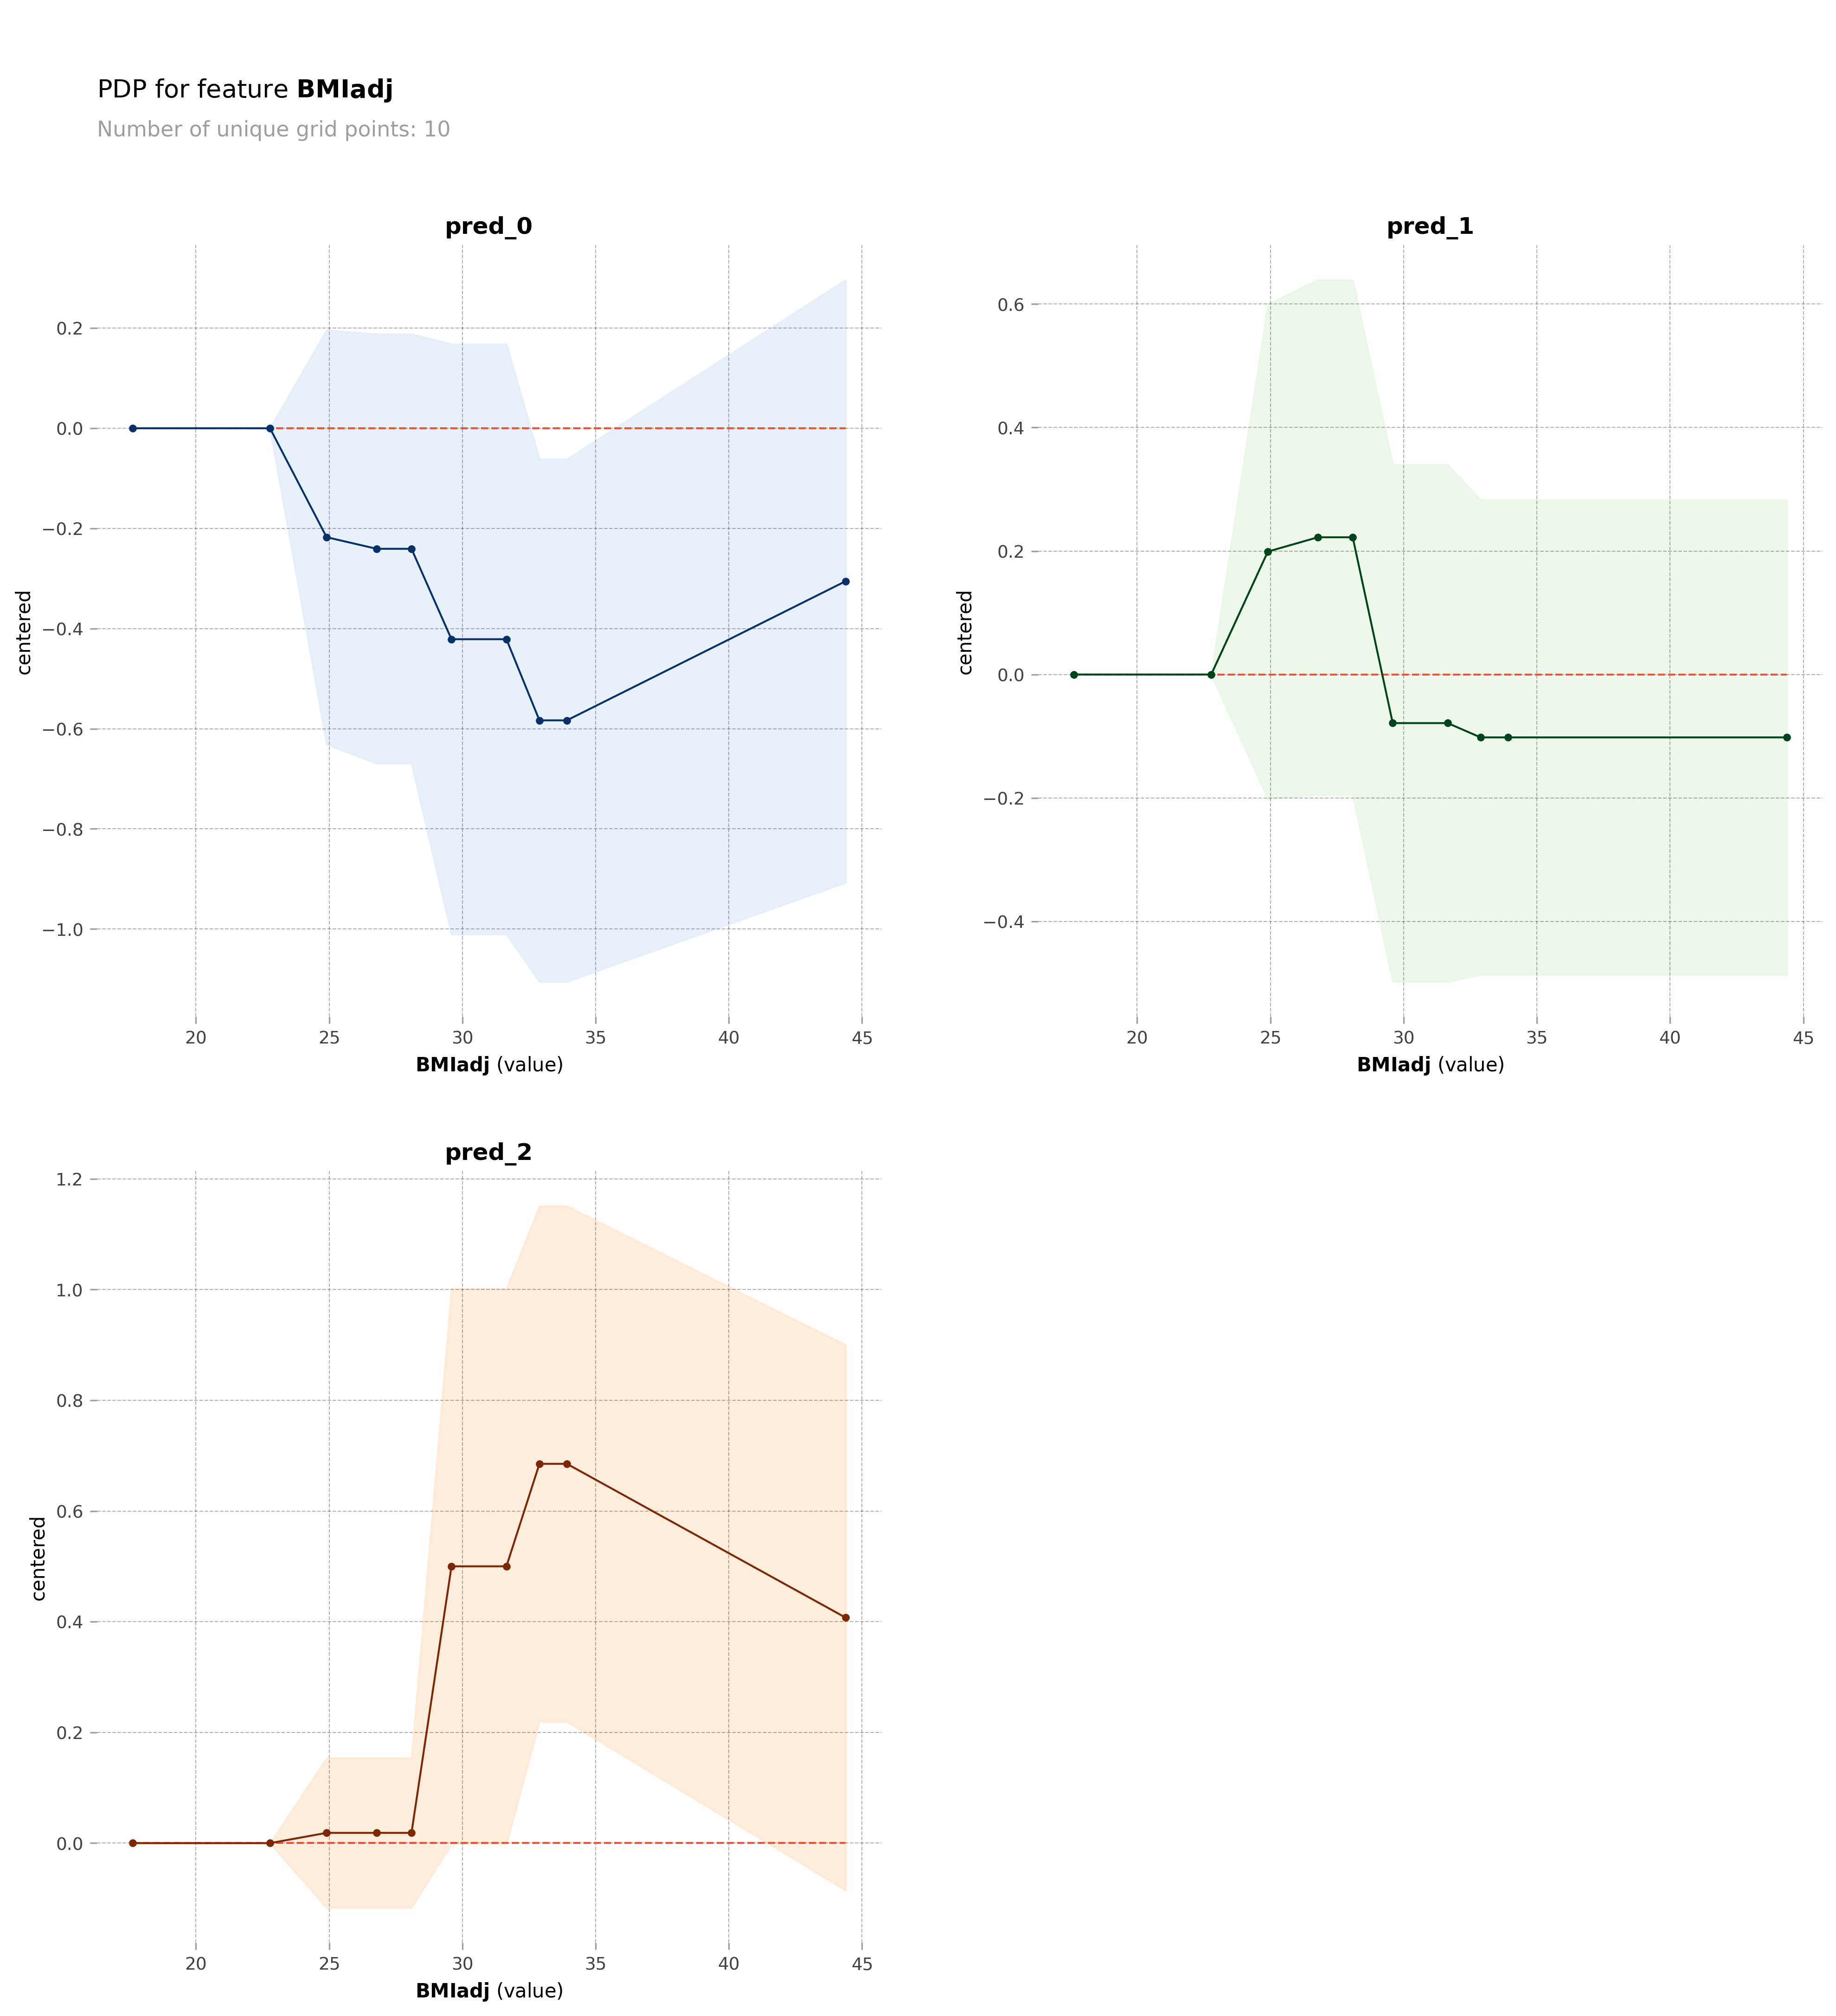

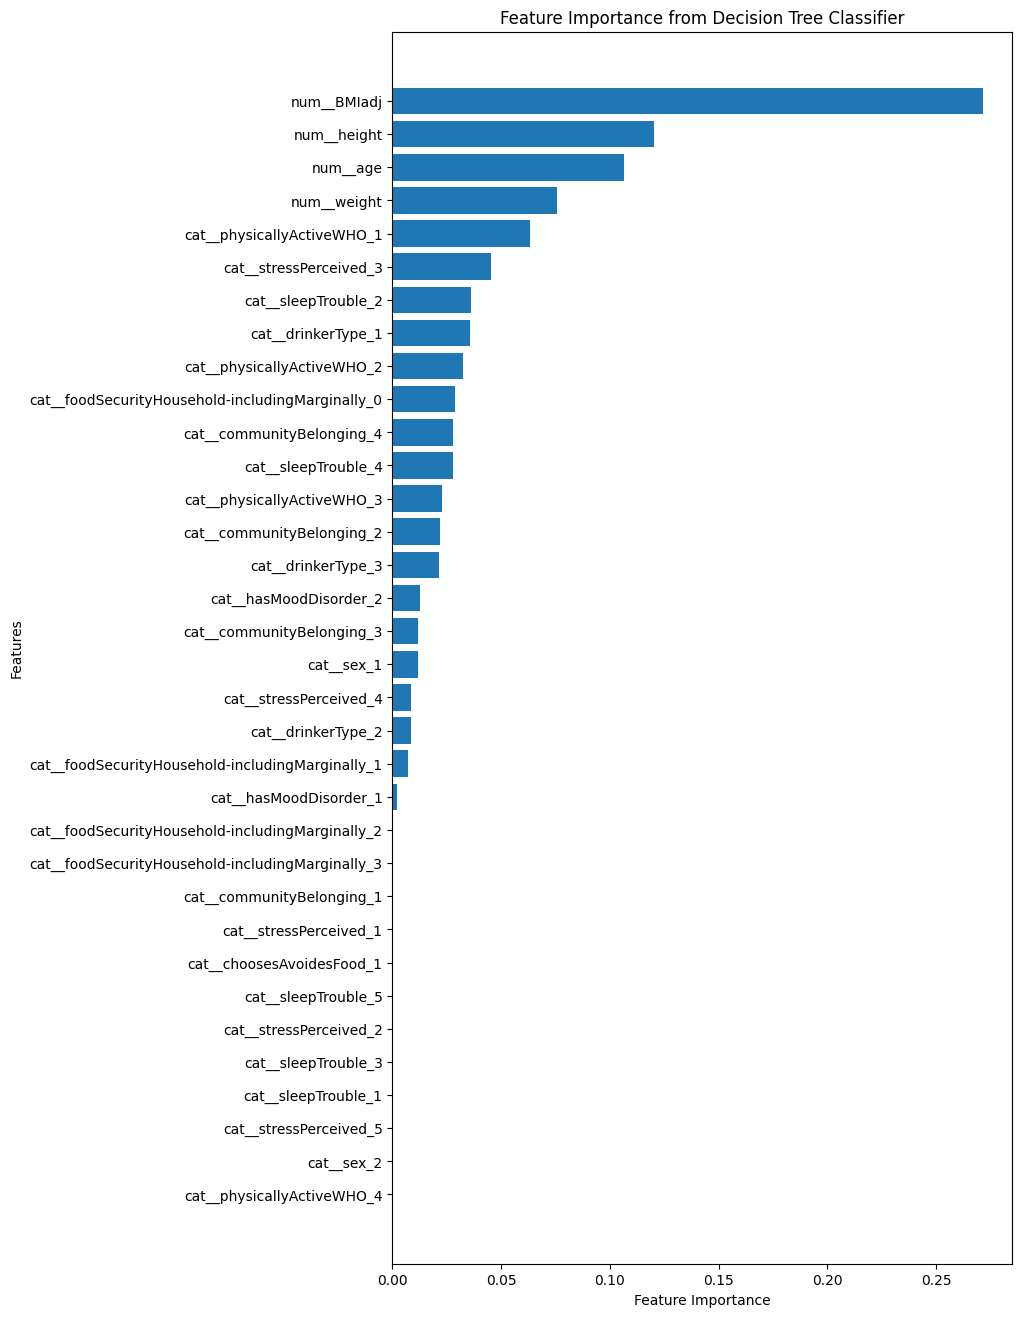

In [ ]:

# Specify the feature
feature_of_interest = "BMIadj"

# Extract the best estimator
best_model = searchDT.best_estimator_

# Create DataFrame with feature names
df = pd.DataFrame(X, columns=features)

# Generate PDP for a specific feature
dp_dist = pdp.PDPIsolate(model=best_model, model_features=features, feature_name=feature_of_interest, feature=feature_of_interest, df=df, n_classes=3)
fig, axes = dp_dist.plot(engine='matplotlib')

feature_importance = best_model.named_steps['classifier'].feature_importances_

preprocessing_step_names = [name for name, _ in best_model.steps if name != 'classifier']
preprocessed_feature_names = best_model.named_steps[preprocessing_step_names[-1]].get_feature_names_out()

# Sort feature importance in descending order
sorted_idx = np.argsort(feature_importance)


n_features = len(preprocessed_feature_names)
plt.figure(figsize=(8, 16))
plt.barh(range(n_features), feature_importance[sorted_idx], align='center')
plt.yticks(np.arange(n_features), preprocessed_feature_names[sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from Decision Tree Classifier')
plt.show()


## Model 2 - Random Forest

In [ ]:

# Define parameter grid for hyperparameter tuning
param_grid = {
    'classifier__n_estimators': range(2, 50),
    'classifier__max_depth': range(1, 50, 1),             # Maximum depth of the tree
    'classifier__min_samples_split': range(2, 10),        # Minimum number of samples required to split an internal node
    'classifier__min_samples_leaf': range(1, 10),         # Minimum number of samples required to be at a leaf node
    'classifier__max_features': range(5, 10),
    'classifier__bootstrap': [True, False]
}


# Append Random Forest classifier
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state = random_state,
                                          n_jobs = 4))  # Random Forest classifier
])

# Define outer cross-validation splits
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

# Inner cross-validation for hyperparameter tuning
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Define search method
searchRF = RandomizedSearchCV(model, param_grid, cv=inner_cv, scoring='f1_macro')


# Initialize lists to store results
train_accuracies = []
train_precisions = []
train_recalls = []
train_specificities = []
train_f1s = []
train_error_rates = []
train_mses = []
train_rmses = []

test_accuracies = []
test_precisions = []
test_recalls = []
test_specificities = []
test_f1s = []
test_error_rates = []
test_mses = []
test_rmses = []

val_accuracies = []
val_precisions = []
val_recalls = []
val_specificities = []
val_f1s = []
val_error_rates = []
val_mses = []
val_rmses = []

roc_auc_train_all = []
roc_auc_val_all = []
roc_auc_test_all = []

f1s[1] = []


# Outer cross-validation loop
for temp_index, test_index in outer_cv.split(X, y):
    X_temp, X_test = X.iloc[temp_index], X.iloc[test_index]
    y_temp, y_test = y.iloc[temp_index], y.iloc[test_index]

    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, random_state=random_state)

    # Fit search to inner training data
    searchRF.fit(X_train, y_train)

    # Get the best estimator
    best_model = searchRF.best_estimator_

    # Predictions on training and test set
    y_train_pred = best_model.predict(X_train)
    y_val_pred = best_model.predict(X_val)
    y_test_pred = best_model.predict(X_test)

    # Calculate accuracy, precision, recall, specificity, error rate, MSE, RMSE, and F1 score for training set
    train_accuracies.append(100*accuracy_score(y_train, y_train_pred))
    train_precisions.append(100*precision_score(y_train, y_train_pred, average='macro', zero_division=0))
    train_recalls.append(100*recall_score(y_train, y_train_pred, average='macro', zero_division=0))
    train_specificities.append(100*specificity_score(y_train, y_train_pred))
    train_f1s.append(100*f1_score(y_train, y_train_pred, average='macro', zero_division=0))
    train_error_rates.append(1 - accuracy_score(y_train, y_train_pred))
    train_mses.append(mean_squared_error(y_train, y_train_pred))
    train_rmses.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))

    # Calculate accuracy, precision, recall, specificity, error rate, MSE, RMSE, and F1 score for test set
    test_accuracies.append(100*accuracy_score(y_test, y_test_pred))
    test_precisions.append(100*precision_score(y_test, y_test_pred, average='macro', zero_division=0))
    test_recalls.append(100*recall_score(y_test, y_test_pred, average='macro', zero_division=0))
    test_specificities.append(100*specificity_score(y_test, y_test_pred))
    test_f1s.append(100*f1_score(y_test, y_test_pred, average='macro', zero_division=0))
    test_error_rates.append(1 - accuracy_score(y_test, y_test_pred))
    test_mses.append(mean_squared_error(y_test, y_test_pred))
    test_rmses.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

    # Calculate accuracy, precision, recall, specificity, error rate, MSE, RMSE, and F1 score for validation set
    val_accuracies.append(100*accuracy_score(y_val, y_val_pred))
    val_precisions.append(100*precision_score(y_val, y_val_pred, average='macro', zero_division=0))
    val_recalls.append(100*recall_score(y_val, y_val_pred, average='macro', zero_division=0))
    val_specificities.append(100*specificity_score(y_val, y_val_pred))
    val_f1s.append(100*f1_score(y_val, y_val_pred, average='macro', zero_division=0))
    val_error_rates.append(1 - accuracy_score(y_val, y_val_pred))
    val_mses.append(mean_squared_error(y_val, y_val_pred))
    val_rmses.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))

    f1s[1].append(100*f1_score(y_test, y_test_pred, average='macro', zero_division=0))


    #-------------------
    #-------------------

    # Binarize the labels
    y_train_binarized = label_binarize(y_train, classes=np.unique(y_train))
    y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
    y_val_binarized = label_binarize(y_val, classes=np.unique(y_val))

    # Calculate probabilities for each class
    y_train_probs = searchRF.predict_proba(X_train)
    y_test_probs = searchRF.predict_proba(X_test)
    y_val_probs = searchRF.predict_proba(X_val)

    # Calculate ROC curve and AUC for each class
    roc_auc_train = list()
    roc_auc_test = list()
    roc_auc_val = list()

    for i in range(len(np.unique(y_train))):
        fpr_train_tmp, tpr_train_tmp, thr_train_tmp = roc_curve(y_train_binarized[:, i], y_train_probs[:, i])
        roc_auc_train_tmp = auc(fpr_train_tmp, tpr_train_tmp)
        roc_auc_train.append(roc_auc_train_tmp)

        fpr_test_tmp, tpr_test_tmp, thr_test_tmp = roc_curve(y_test_binarized[:, i], y_test_probs[:, i])
        roc_auc_test_tmp = auc(fpr_test_tmp, tpr_test_tmp)
        roc_auc_test.append(roc_auc_test_tmp)

        fpr_val_tmp, tpr_val_tmp, thr_val_tmp = roc_curve(y_val_binarized[:, i], y_val_probs[:, i])
        roc_auc_val_tmp = auc(fpr_val_tmp, tpr_val_tmp)
        roc_auc_val.append(roc_auc_val_tmp)


    roc_auc_train_all.append(roc_auc_train)
    roc_auc_test_all.append(roc_auc_test)
    roc_auc_val_all.append(roc_auc_val)

auc_train = my_avg_std(roc_auc_train_all)
auc_test = my_avg_std(roc_auc_test_all)
auc_val = my_avg_std(roc_auc_val_all)



# Print average accuracies across all folds
print("F1-score Training: {}(+/- {}):".format(round(np.mean(train_f1s), 2), round(np.std(train_f1s), 2)))
print("F1-score Val: {}(+/- {}):".format(round(np.mean(val_f1s), 2), round(np.std(val_f1s), 2)))
print("F1-score Test: {}(+/- {}):".format(round(np.mean(test_f1s), 2), round(np.std(test_f1s), 2)))

print()

print("Recall Training: {}(+/- {}):".format(round(np.mean(train_recalls), 2), round(np.std(train_recalls), 2)))
print("Recall Val: {}(+/- {}):".format(round(np.mean(val_recalls), 2), round(np.std(val_recalls), 2)))
print("Recall Test: {}(+/- {}):".format(round(np.mean(test_recalls), 2), round(np.std(test_recalls), 2)))

print()

print("Precision Training: {}(+/- {}):".format(round(np.mean(train_precisions), 2), round(np.std(train_precisions), 2)))
print("Precision Val: {}(+/- {}):".format(round(np.mean(val_precisions), 2), round(np.std(val_precisions), 2)))
print("Precision Test: {}(+/- {}):".format(round(np.mean(test_precisions), 2), round(np.std(test_precisions), 2)))

print()

print("Accuracy Training: {}(+/- {}):".format(round(np.mean(train_accuracies), 2), round(np.std(train_accuracies), 2)))
print("Accuracy Val: {}(+/- {}):".format(round(np.mean(val_accuracies), 2), round(np.std(val_accuracies), 2)))
print("Accuracy Test: {}(+/- {}):".format(round(np.mean(test_accuracies), 2), round(np.std(test_accuracies), 2)))

print()

print("Specifity Training: {}(+/- {}):".format(round(np.mean(train_specificities), 2), round(np.std(train_specificities), 2)))
print("Specifity Val: {}(+/- {}):".format(round(np.mean(val_specificities), 2), round(np.std(val_specificities), 2)))
print("Specifity Test: {}(+/- {}):".format(round(np.mean(test_specificities), 2), round(np.std(test_specificities), 2)))

print()

print("ErrorRate Training: {}(+/- {}):".format(round(np.mean(train_error_rates), 2), round(np.std(train_error_rates), 2)))
print("ErrorRate Val: {}(+/- {}):".format(round(np.mean(val_error_rates), 2), round(np.std(val_error_rates), 2)))
print("ErrorRate Test: {}(+/- {}):".format(round(np.mean(test_error_rates), 2), round(np.std(test_error_rates), 2)))

print()

print("MSE Training: {}(+/- {}):".format(round(np.mean(train_mses), 2), round(np.std(train_mses), 2)))
print("MSE Val: {}(+/- {}):".format(round(np.mean(val_mses), 2), round(np.std(val_mses), 2)))
print("MSE Test: {}(+/- {}):".format(round(np.mean(test_mses), 2), round(np.std(test_mses), 2)))

print()

print("RMSE Training: {}(+/- {}):".format(round(np.mean(train_rmses), 2), round(np.std(train_rmses), 2)))
print("RMSE Val: {}(+/- {}):".format(round(np.mean(val_rmses), 2), round(np.std(val_rmses), 2)))
print("RMSE Test: {}(+/- {}):".format(round(np.mean(test_rmses), 2), round(np.std(test_rmses), 2)))

print()

print("AUC Class 0 Training: {}(+/- {}):".format(round(auc_train[0][0], 2), round(auc_train[1][0], 2)))
print("AUC Class 0 Val: {}(+/- {}):".format(round(auc_val[0][0], 2), round(auc_val[1][0], 2)))
print("AUC Class 0 Test: {}(+/- {}):".format(round(auc_test[0][0], 2), round(auc_test[1][0], 2)))

print()

print("AUC Class 1 Training: {}(+/- {}):".format(round(auc_train[0][1], 2), round(auc_train[1][1], 2)))
print("AUC Class 1 Val: {}(+/- {}):".format(round(auc_val[0][1], 2), round(auc_val[1][1], 2)))
print("AUC Class 1 Test: {}(+/- {}):".format(round(auc_test[0][1], 2), round(auc_test[1][1], 2)))

print()

print("AUC Class 2 Training: {}(+/- {}):".format(round(auc_train[0][2], 2), round(auc_train[1][2], 2)))
print("AUC Class 2 Val: {}(+/- {}):".format(round(auc_val[0][2], 2), round(auc_val[1][2], 2)))
print("AUC Class 2 Test: {}(+/- {}):".format(round(auc_test[0][2], 2), round(auc_test[1][2], 2)))

F1-score Training: 98.35(+/- 1.26):
F1-score Val: 80.81(+/- 6.33):
F1-score Test: 84.78(+/- 8.11):

Recall Training: 98.36(+/- 1.27):
Recall Val: 82.52(+/- 6.73):
Recall Test: 84.76(+/- 8.2):

Precision Training: 98.41(+/- 1.19):
Precision Val: 82.24(+/- 5.96):
Precision Test: 86.82(+/- 7.5):

Accuracy Training: 98.34(+/- 1.27):
Accuracy Val: 81.5(+/- 5.5):
Accuracy Test: 84.74(+/- 8.18):

Specifity Training: 98.41(+/- 1.19):
Specifity Val: 82.24(+/- 5.96):
Specifity Test: 86.82(+/- 7.5):

ErrorRate Training: 0.02(+/- 0.01):
ErrorRate Val: 0.18(+/- 0.06):
ErrorRate Test: 0.15(+/- 0.08):

MSE Training: 0.05(+/- 0.04):
MSE Val: 0.4(+/- 0.22):
MSE Test: 0.36(+/- 0.32):

RMSE Training: 0.18(+/- 0.12):
RMSE Val: 0.6(+/- 0.18):
RMSE Test: 0.54(+/- 0.27):

AUC Class 0 Training: 1.0(+/- 0.0):
AUC Class 0 Val: 0.93(+/- 0.07):
AUC Class 0 Test: 0.92(+/- 0.09):

AUC Class 1 Training: 1.0(+/- 0.0):
AUC Class 1 Val: 0.94(+/- 0.04):
AUC Class 1 Test: 0.97(+/- 0.04):

AUC Class 2 Training: 1.0(+/- 0.

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

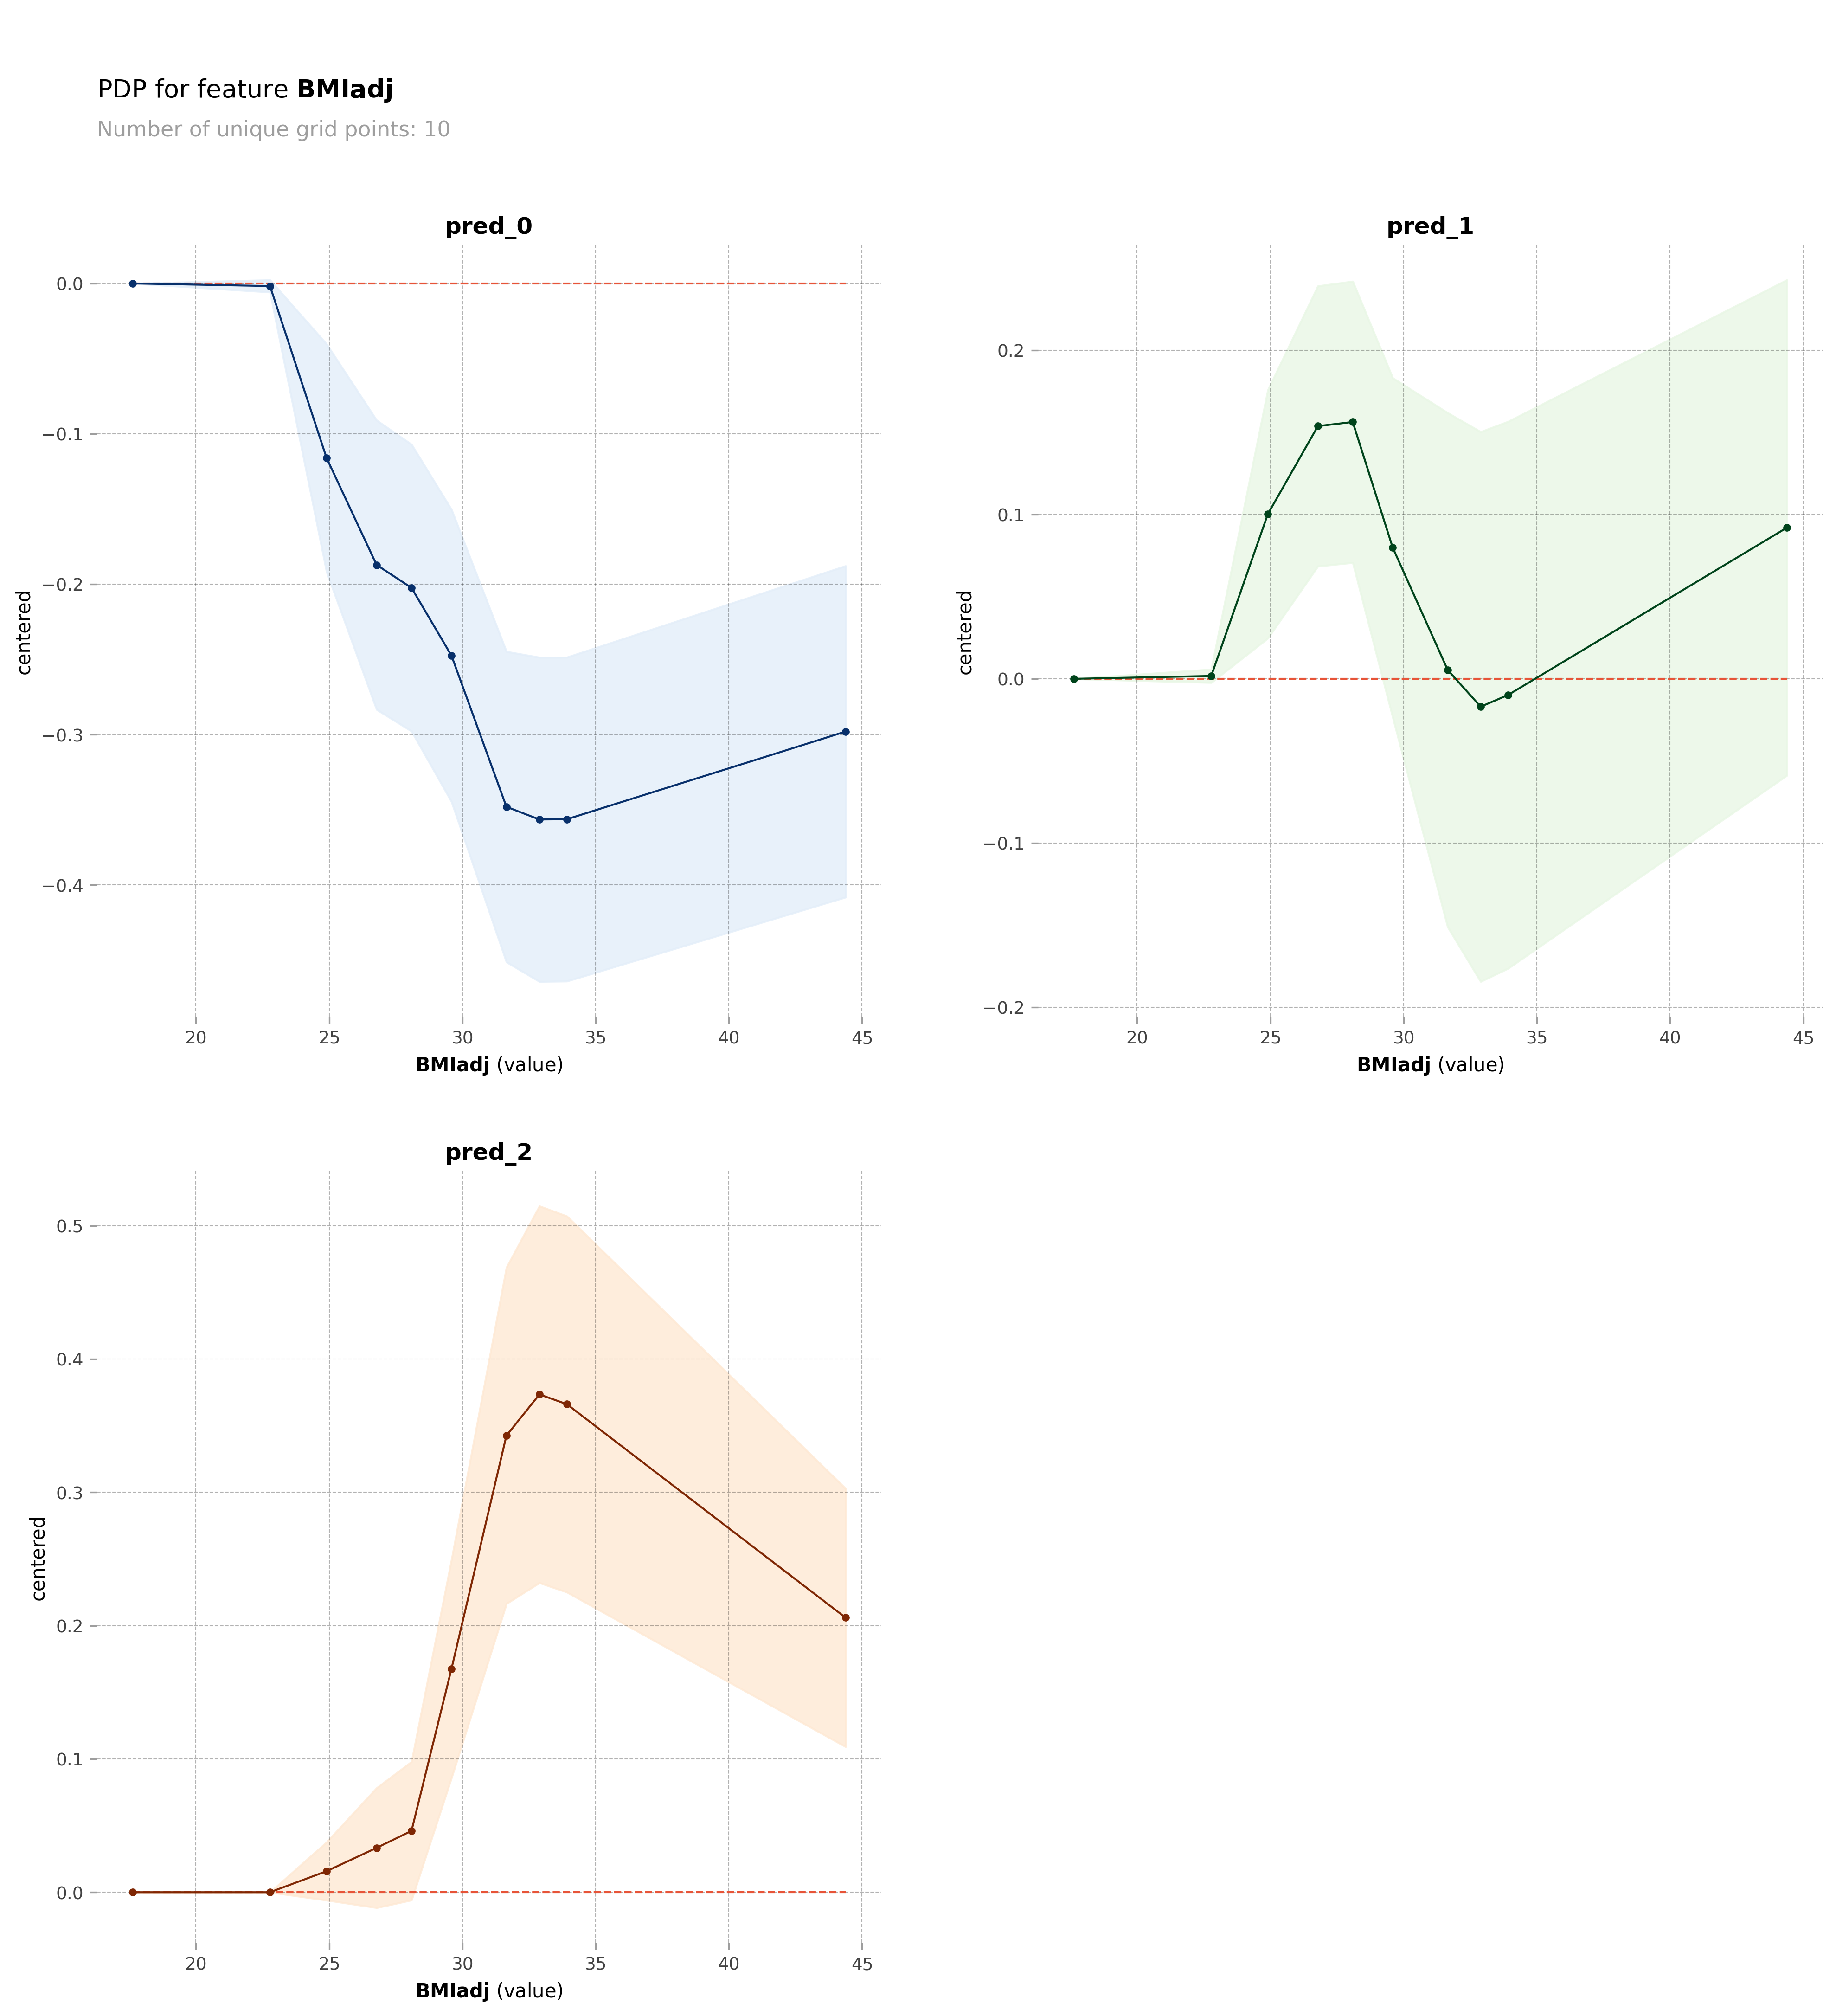

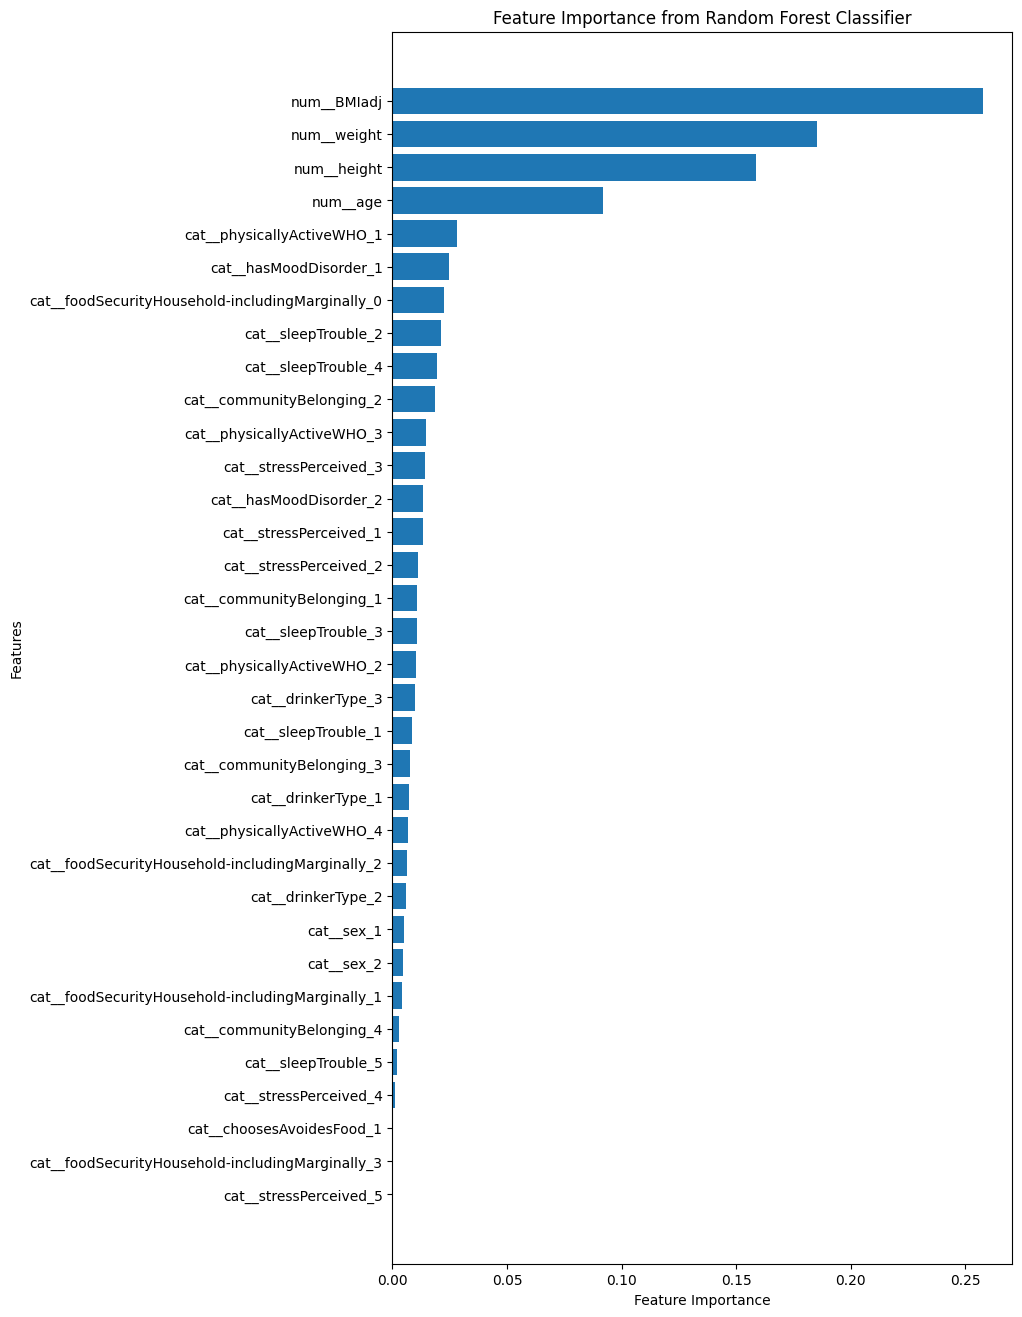

In [ ]:

# Specify the feature
feature_of_interest = "BMIadj"

# Extract the best estimator
best_model = searchRF.best_estimator_

# Create DataFrame with feature names
df = pd.DataFrame(X, columns=features)

# Generate PDP for a specific feature
dp_dist = pdp.PDPIsolate(model=best_model, model_features=features, feature_name=feature_of_interest, feature=feature_of_interest, df=df, n_classes=3)
fig, axes = dp_dist.plot(engine='matplotlib')


feature_importance = best_model.named_steps['classifier'].feature_importances_

preprocessing_step_names = [name for name, _ in best_model.steps if name != 'classifier']
preprocessed_feature_names = best_model.named_steps[preprocessing_step_names[-1]].get_feature_names_out()

# Sort feature importance in descending order
sorted_idx = np.argsort(feature_importance)

n_features = len(preprocessed_feature_names)
plt.figure(figsize=(8, 16))
plt.barh(range(n_features), feature_importance[sorted_idx], align='center')
plt.yticks(np.arange(n_features), preprocessed_feature_names[sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from Random Forest Classifier')
plt.show()


## Model 3 - KNN (K Nearest Neighbor)

In [ ]:
# Define parameter grid for hyperparameter tuning
param_grid = {
    'classifier__n_neighbors': range(1, 100),
    'classifier__leaf_size': range(1, 100),
}


# Append Random Forest classifier
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_jobs = 4,
                                        weights = 'uniform',
                                        algorithm = 'auto'))
])

# Define outer cross-validation splits
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

# Inner cross-validation for hyperparameter tuning
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Define search method
searchKNN = RandomizedSearchCV(model, param_grid, cv=inner_cv, scoring='f1_macro')


# Initialize lists to store results
train_accuracies = []
train_precisions = []
train_recalls = []
train_specificities = []
train_f1s = []
train_error_rates = []
train_mses = []
train_rmses = []

test_accuracies = []
test_precisions = []
test_recalls = []
test_specificities = []
test_f1s = []
test_error_rates = []
test_mses = []
test_rmses = []


val_accuracies = []
val_precisions = []
val_recalls = []
val_specificities = []
val_f1s = []
val_error_rates = []
val_mses = []
val_rmses = []

roc_auc_train_all = []
roc_auc_val_all = []
roc_auc_test_all = []

f1s[2] = []


# Outer cross-validation loop
for temp_index, test_index in outer_cv.split(X, y):
    X_temp, X_test = X.iloc[temp_index], X.iloc[test_index]
    y_temp, y_test = y.iloc[temp_index], y.iloc[test_index]

    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, random_state=random_state)

    # Fit search to inner training data
    searchKNN.fit(X_train, y_train)

    # Get the best estimator
    best_model = searchKNN.best_estimator_

    # Predictions on training and test set
    y_train_pred = best_model.predict(X_train)
    y_val_pred = best_model.predict(X_val)
    y_test_pred = best_model.predict(X_test)

    # Calculate accuracy, precision, recall, specificity, error rate, MSE, RMSE, and F1 score for training set
    train_accuracies.append(100*accuracy_score(y_train, y_train_pred))
    train_precisions.append(100*precision_score(y_train, y_train_pred, average='macro', zero_division=0))
    train_recalls.append(100*recall_score(y_train, y_train_pred, average='macro', zero_division=0))
    train_specificities.append(100*specificity_score(y_train, y_train_pred))
    train_f1s.append(100*f1_score(y_train, y_train_pred, average='macro', zero_division=0))
    train_error_rates.append(1 - accuracy_score(y_train, y_train_pred))
    train_mses.append(mean_squared_error(y_train, y_train_pred))
    train_rmses.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))

    # Calculate accuracy, precision, recall, specificity, error rate, MSE, RMSE, and F1 score for test set
    test_accuracies.append(100*accuracy_score(y_test, y_test_pred))
    test_precisions.append(100*precision_score(y_test, y_test_pred, average='macro', zero_division=0))
    test_recalls.append(100*recall_score(y_test, y_test_pred, average='macro', zero_division=0))
    test_specificities.append(100*specificity_score(y_test, y_test_pred))
    test_f1s.append(100*f1_score(y_test, y_test_pred, average='macro', zero_division=0))
    test_error_rates.append(1 - accuracy_score(y_test, y_test_pred))
    test_mses.append(mean_squared_error(y_test, y_test_pred))
    test_rmses.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

    # Calculate accuracy, precision, recall, specificity, error rate, MSE, RMSE, and F1 score for validation set
    val_accuracies.append(100*accuracy_score(y_val, y_val_pred))
    val_precisions.append(100*precision_score(y_val, y_val_pred, average='macro', zero_division=0))
    val_recalls.append(100*recall_score(y_val, y_val_pred, average='macro', zero_division=0))
    val_specificities.append(100*specificity_score(y_val, y_val_pred))
    val_f1s.append(100*f1_score(y_val, y_val_pred, average='macro', zero_division=0))
    val_error_rates.append(1 - accuracy_score(y_val, y_val_pred))
    val_mses.append(mean_squared_error(y_val, y_val_pred))
    val_rmses.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))

    f1s[2].append(100*f1_score(y_test, y_test_pred, average='macro', zero_division=0))


    #-------------------
    #-------------------

    # Binarize the labels
    y_train_binarized = label_binarize(y_train, classes=np.unique(y_train))
    y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
    y_val_binarized = label_binarize(y_val, classes=np.unique(y_val))

    # Calculate probabilities for each class
    y_train_probs = searchKNN.predict_proba(X_train)
    y_test_probs = searchKNN.predict_proba(X_test)
    y_val_probs = searchKNN.predict_proba(X_val)

    # Calculate ROC curve and AUC for each class
    roc_auc_train = list()
    roc_auc_test = list()
    roc_auc_val = list()

    for i in range(len(np.unique(y_train))):
        fpr_train_tmp, tpr_train_tmp, thr_train_tmp = roc_curve(y_train_binarized[:, i], y_train_probs[:, i])
        roc_auc_train_tmp = auc(fpr_train_tmp, tpr_train_tmp)
        roc_auc_train.append(roc_auc_train_tmp)

        fpr_test_tmp, tpr_test_tmp, thr_test_tmp = roc_curve(y_test_binarized[:, i], y_test_probs[:, i])
        roc_auc_test_tmp = auc(fpr_test_tmp, tpr_test_tmp)
        roc_auc_test.append(roc_auc_test_tmp)

        fpr_val_tmp, tpr_val_tmp, thr_val_tmp = roc_curve(y_val_binarized[:, i], y_val_probs[:, i])
        roc_auc_val_tmp = auc(fpr_val_tmp, tpr_val_tmp)
        roc_auc_val.append(roc_auc_val_tmp)


    roc_auc_train_all.append(roc_auc_train)
    roc_auc_test_all.append(roc_auc_test)
    roc_auc_val_all.append(roc_auc_val)

auc_train = my_avg_std(roc_auc_train_all)
auc_test = my_avg_std(roc_auc_test_all)
auc_val = my_avg_std(roc_auc_val_all)



# Print average accuracies across all folds
print("F1-score Training: {}(+/- {}):".format(round(np.mean(train_f1s), 2), round(np.std(train_f1s), 2)))
print("F1-score Val: {}(+/- {}):".format(round(np.mean(val_f1s), 2), round(np.std(val_f1s), 2)))
print("F1-score Test: {}(+/- {}):".format(round(np.mean(test_f1s), 2), round(np.std(test_f1s), 2)))

print()

print("Recall Training: {}(+/- {}):".format(round(np.mean(train_recalls), 2), round(np.std(train_recalls), 2)))
print("Recall Val: {}(+/- {}):".format(round(np.mean(val_recalls), 2), round(np.std(val_recalls), 2)))
print("Recall Test: {}(+/- {}):".format(round(np.mean(test_recalls), 2), round(np.std(test_recalls), 2)))

print()

print("Precision Training: {}(+/- {}):".format(round(np.mean(train_precisions), 2), round(np.std(train_precisions), 2)))
print("Precision Val: {}(+/- {}):".format(round(np.mean(val_precisions), 2), round(np.std(val_precisions), 2)))
print("Precision Test: {}(+/- {}):".format(round(np.mean(test_precisions), 2), round(np.std(test_precisions), 2)))

print()

print("Accuracy Training: {}(+/- {}):".format(round(np.mean(train_accuracies), 2), round(np.std(train_accuracies), 2)))
print("Accuracy Val: {}(+/- {}):".format(round(np.mean(val_accuracies), 2), round(np.std(val_accuracies), 2)))
print("Accuracy Test: {}(+/- {}):".format(round(np.mean(test_accuracies), 2), round(np.std(test_accuracies), 2)))

print()

print("Specifity Training: {}(+/- {}):".format(round(np.mean(train_specificities), 2), round(np.std(train_specificities), 2)))
print("Specifity Val: {}(+/- {}):".format(round(np.mean(val_specificities), 2), round(np.std(val_specificities), 2)))
print("Specifity Test: {}(+/- {}):".format(round(np.mean(test_specificities), 2), round(np.std(test_specificities), 2)))

print()

print("ErrorRate Training: {}(+/- {}):".format(round(np.mean(train_error_rates), 2), round(np.std(train_error_rates), 2)))
print("ErrorRate Val: {}(+/- {}):".format(round(np.mean(val_error_rates), 2), round(np.std(val_error_rates), 2)))
print("ErrorRate Test: {}(+/- {}):".format(round(np.mean(test_error_rates), 2), round(np.std(test_error_rates), 2)))

print()

print("MSE Training: {}(+/- {}):".format(round(np.mean(train_mses), 2), round(np.std(train_mses), 2)))
print("MSE Val: {}(+/- {}):".format(round(np.mean(val_mses), 2), round(np.std(val_mses), 2)))
print("MSE Test: {}(+/- {}):".format(round(np.mean(test_mses), 2), round(np.std(test_mses), 2)))

print()

print("RMSE Training: {}(+/- {}):".format(round(np.mean(train_rmses), 2), round(np.std(train_rmses), 2)))
print("RMSE Val: {}(+/- {}):".format(round(np.mean(val_rmses), 2), round(np.std(val_rmses), 2)))
print("RMSE Test: {}(+/- {}):".format(round(np.mean(test_rmses), 2), round(np.std(test_rmses), 2)))

print()

print("AUC Class 0 Training: {}(+/- {}):".format(round(auc_train[0][0], 2), round(auc_train[1][0], 2)))
print("AUC Class 0 Val: {}(+/- {}):".format(round(auc_val[0][0], 2), round(auc_val[1][0], 2)))
print("AUC Class 0 Test: {}(+/- {}):".format(round(auc_test[0][0], 2), round(auc_test[1][0], 2)))

print()

print("AUC Class 1 Training: {}(+/- {}):".format(round(auc_train[0][1], 2), round(auc_train[1][1], 2)))
print("AUC Class 1 Val: {}(+/- {}):".format(round(auc_val[0][1], 2), round(auc_val[1][1], 2)))
print("AUC Class 1 Test: {}(+/- {}):".format(round(auc_test[0][1], 2), round(auc_test[1][1], 2)))

print()

print("AUC Class 2 Training: {}(+/- {}):".format(round(auc_train[0][2], 2), round(auc_train[1][2], 2)))
print("AUC Class 2 Val: {}(+/- {}):".format(round(auc_val[0][2], 2), round(auc_val[1][2], 2)))
print("AUC Class 2 Test: {}(+/- {}):".format(round(auc_test[0][2], 2), round(auc_test[1][2], 2)))

F1-score Training: 87.64(+/- 7.61):
F1-score Val: 66.06(+/- 10.88):
F1-score Test: 69.88(+/- 8.18):

Recall Training: 87.99(+/- 7.35):
Recall Val: 67.43(+/- 10.25):
Recall Test: 71.31(+/- 7.86):

Precision Training: 88.6(+/- 6.84):
Precision Val: 70.12(+/- 11.16):
Precision Test: 73.83(+/- 8.76):

Accuracy Training: 87.85(+/- 7.44):
Accuracy Val: 68.5(+/- 9.23):
Accuracy Test: 71.32(+/- 7.74):

Specifity Training: 88.6(+/- 6.84):
Specifity Val: 70.12(+/- 11.16):
Specifity Test: 73.83(+/- 8.76):

ErrorRate Training: 0.12(+/- 0.07):
ErrorRate Val: 0.31(+/- 0.09):
ErrorRate Test: 0.29(+/- 0.08):

MSE Training: 0.25(+/- 0.15):
MSE Val: 0.46(+/- 0.19):
MSE Test: 0.59(+/- 0.17):

RMSE Training: 0.44(+/- 0.23):
RMSE Val: 0.67(+/- 0.14):
RMSE Test: 0.76(+/- 0.11):

AUC Class 0 Training: 0.97(+/- 0.02):
AUC Class 0 Val: 0.82(+/- 0.07):
AUC Class 0 Test: 0.76(+/- 0.1):

AUC Class 1 Training: 0.97(+/- 0.03):
AUC Class 1 Val: 0.81(+/- 0.07):
AUC Class 1 Test: 0.86(+/- 0.08):

AUC Class 2 Training:

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

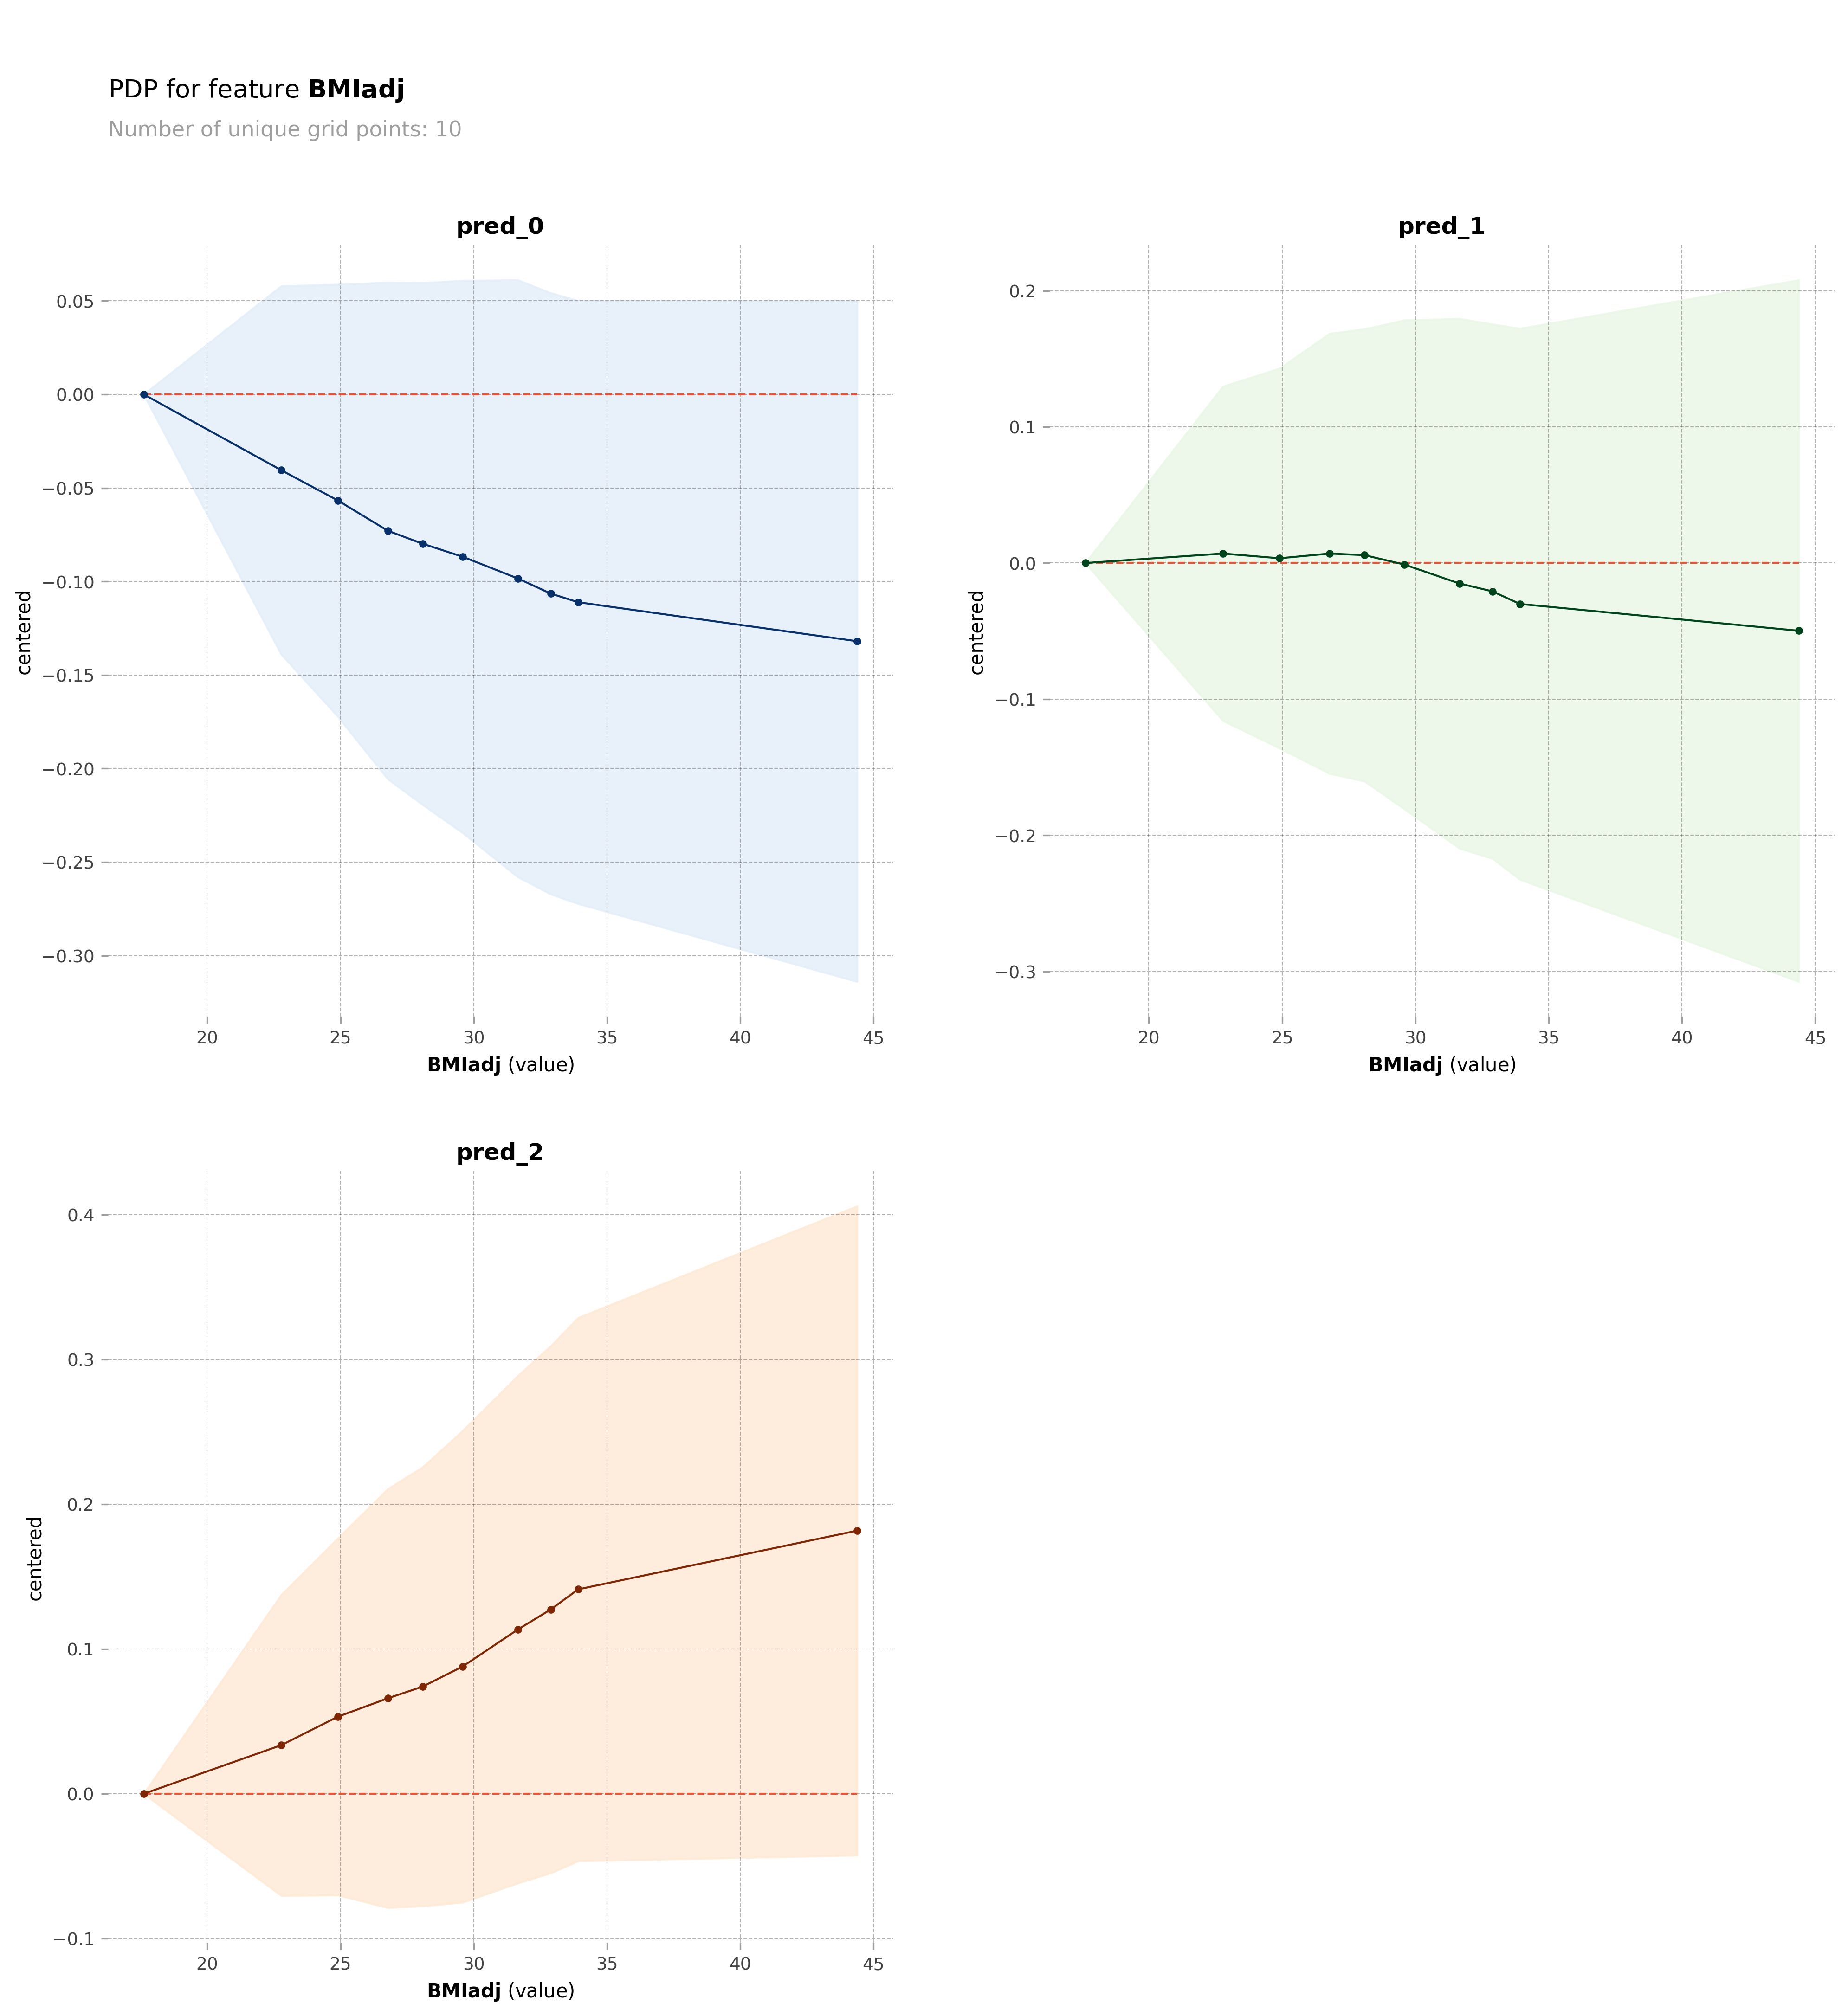

In [ ]:

# Specify the feature
feature_of_interest = "BMIadj"

# Extract the best estimator
best_model = searchKNN.best_estimator_

# Create DataFrame with feature names
df = pd.DataFrame(X, columns=features)

# Generate PDP for a specific feature
dp_dist = pdp.PDPIsolate(model=best_model, model_features=features, feature_name=feature_of_interest, feature=feature_of_interest, df=df, n_classes=3)
fig, axes = dp_dist.plot(engine='matplotlib')



## Model 4 - XG BOOST

In [ ]:

# Define parameter grid for hyperparameter tuning
param_grid = {
    'classifier__n_estimators': range(2, 50),
    'classifier__max_depth': range(1, 50),
    'classifier__reg_alpha': np.linspace(0.1, 0.3, 5),
    'classifier__reg_lambda': np.linspace(0.1, 0.5, 5),
    'classifier__subsample': np.linspace(0.6, 0.9, 5),
    'classifier__gamma': np.linspace(0.001, 0.005, 5)
}


# Append Random Forest classifier
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(random_state = random_state,
                                     n_jobs = 4,
                                     objective='multi:softmax',
                                     num_class=3,
                                     learning_rate=0.01)
    )
])



# Define outer cross-validation splits
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

# Inner cross-validation for hyperparameter tuning
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Define search method
searchXG = RandomizedSearchCV(model, param_grid, cv=inner_cv, scoring='f1_macro')


# Initialize lists to store results
train_accuracies = []
train_precisions = []
train_recalls = []
train_specificities = []
train_f1s = []
train_error_rates = []
train_mses = []
train_rmses = []

test_accuracies = []
test_precisions = []
test_recalls = []
test_specificities = []
test_f1s = []
test_error_rates = []
test_mses = []
test_rmses = []


val_accuracies = []
val_precisions = []
val_recalls = []
val_specificities = []
val_f1s = []
val_error_rates = []
val_mses = []
val_rmses = []

roc_auc_train_all = []
roc_auc_val_all = []
roc_auc_test_all = []

f1s[3].append(100*f1_score(y_test, y_test_pred, average='macro', zero_division=0))


# Outer cross-validation loop
for temp_index, test_index in outer_cv.split(X, y):
    X_temp, X_test = X.iloc[temp_index], X.iloc[test_index]
    y_temp, y_test = y.iloc[temp_index], y.iloc[test_index]

    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, random_state=random_state)

    # Fit search to inner training data
    searchXG.fit(X_train, y_train)

    # Get the best estimator
    best_model = searchXG.best_estimator_

    # Predictions on training and test set
    y_train_pred = best_model.predict(X_train)
    y_val_pred = best_model.predict(X_val)
    y_test_pred = best_model.predict(X_test)

    # Calculate accuracy, precision, recall, specificity, error rate, MSE, RMSE, and F1 score for training set
    train_accuracies.append(100*accuracy_score(y_train, y_train_pred))
    train_precisions.append(100*precision_score(y_train, y_train_pred, average='macro', zero_division=0))
    train_recalls.append(100*recall_score(y_train, y_train_pred, average='macro', zero_division=0))
    train_specificities.append(100*specificity_score(y_train, y_train_pred))
    train_f1s.append(100*f1_score(y_train, y_train_pred, average='macro', zero_division=0))
    train_error_rates.append(1 - accuracy_score(y_train, y_train_pred))
    train_mses.append(mean_squared_error(y_train, y_train_pred))
    train_rmses.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))

    # Calculate accuracy, precision, recall, specificity, error rate, MSE, RMSE, and F1 score for test set
    test_accuracies.append(100*accuracy_score(y_test, y_test_pred))
    test_precisions.append(100*precision_score(y_test, y_test_pred, average='macro', zero_division=0))
    test_recalls.append(100*recall_score(y_test, y_test_pred, average='macro', zero_division=0))
    test_specificities.append(100*specificity_score(y_test, y_test_pred))
    test_f1s.append(100*f1_score(y_test, y_test_pred, average='macro', zero_division=0))
    test_error_rates.append(1 - accuracy_score(y_test, y_test_pred))
    test_mses.append(mean_squared_error(y_test, y_test_pred))
    test_rmses.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

    # Calculate accuracy, precision, recall, specificity, error rate, MSE, RMSE, and F1 score for validation set
    val_accuracies.append(100*accuracy_score(y_val, y_val_pred))
    val_precisions.append(100*precision_score(y_val, y_val_pred, average='macro', zero_division=0))
    val_recalls.append(100*recall_score(y_val, y_val_pred, average='macro', zero_division=0))
    val_specificities.append(100*specificity_score(y_val, y_val_pred))
    val_f1s.append(100*f1_score(y_val, y_val_pred, average='macro', zero_division=0))
    val_error_rates.append(1 - accuracy_score(y_val, y_val_pred))
    val_mses.append(mean_squared_error(y_val, y_val_pred))
    val_rmses.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))

    f1s[3].append(100*f1_score(y_test, y_test_pred, average='macro', zero_division=0))


    #-------------------
    #-------------------

    # Binarize the labels
    y_train_binarized = label_binarize(y_train, classes=np.unique(y_train))
    y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
    y_val_binarized = label_binarize(y_val, classes=np.unique(y_val))

    # Calculate probabilities for each class
    y_train_probs = searchXG.predict_proba(X_train)
    y_test_probs = searchXG.predict_proba(X_test)
    y_val_probs = searchXG.predict_proba(X_val)

    # Calculate ROC curve and AUC for each class
    roc_auc_train = list()
    roc_auc_test = list()
    roc_auc_val = list()

    for i in range(len(np.unique(y_train))):
        fpr_train_tmp, tpr_train_tmp, thr_train_tmp = roc_curve(y_train_binarized[:, i], y_train_probs[:, i])
        roc_auc_train_tmp = auc(fpr_train_tmp, tpr_train_tmp)
        roc_auc_train.append(roc_auc_train_tmp)

        fpr_test_tmp, tpr_test_tmp, thr_test_tmp = roc_curve(y_test_binarized[:, i], y_test_probs[:, i])
        roc_auc_test_tmp = auc(fpr_test_tmp, tpr_test_tmp)
        roc_auc_test.append(roc_auc_test_tmp)

        fpr_val_tmp, tpr_val_tmp, thr_val_tmp = roc_curve(y_val_binarized[:, i], y_val_probs[:, i])
        roc_auc_val_tmp = auc(fpr_val_tmp, tpr_val_tmp)
        roc_auc_val.append(roc_auc_val_tmp)


    roc_auc_train_all.append(roc_auc_train)
    roc_auc_test_all.append(roc_auc_test)
    roc_auc_val_all.append(roc_auc_val)

auc_train = my_avg_std(roc_auc_train_all)
auc_test = my_avg_std(roc_auc_test_all)
auc_val = my_avg_std(roc_auc_val_all)



# Print average accuracies across all folds
print("F1-score Training: {}(+/- {}):".format(round(np.mean(train_f1s), 2), round(np.std(train_f1s), 2)))
print("F1-score Val: {}(+/- {}):".format(round(np.mean(val_f1s), 2), round(np.std(val_f1s), 2)))
print("F1-score Test: {}(+/- {}):".format(round(np.mean(test_f1s), 2), round(np.std(test_f1s), 2)))

print()

print("Recall Training: {}(+/- {}):".format(round(np.mean(train_recalls), 2), round(np.std(train_recalls), 2)))
print("Recall Val: {}(+/- {}):".format(round(np.mean(val_recalls), 2), round(np.std(val_recalls), 2)))
print("Recall Test: {}(+/- {}):".format(round(np.mean(test_recalls), 2), round(np.std(test_recalls), 2)))

print()

print("Precision Training: {}(+/- {}):".format(round(np.mean(train_precisions), 2), round(np.std(train_precisions), 2)))
print("Precision Val: {}(+/- {}):".format(round(np.mean(val_precisions), 2), round(np.std(val_precisions), 2)))
print("Precision Test: {}(+/- {}):".format(round(np.mean(test_precisions), 2), round(np.std(test_precisions), 2)))

print()

print("Accuracy Training: {}(+/- {}):".format(round(np.mean(train_accuracies), 2), round(np.std(train_accuracies), 2)))
print("Accuracy Val: {}(+/- {}):".format(round(np.mean(val_accuracies), 2), round(np.std(val_accuracies), 2)))
print("Accuracy Test: {}(+/- {}):".format(round(np.mean(test_accuracies), 2), round(np.std(test_accuracies), 2)))

print()

print("Specifity Training: {}(+/- {}):".format(round(np.mean(train_specificities), 2), round(np.std(train_specificities), 2)))
print("Specifity Val: {}(+/- {}):".format(round(np.mean(val_specificities), 2), round(np.std(val_specificities), 2)))
print("Specifity Test: {}(+/- {}):".format(round(np.mean(test_specificities), 2), round(np.std(test_specificities), 2)))

print()

print("ErrorRate Training: {}(+/- {}):".format(round(np.mean(train_error_rates), 2), round(np.std(train_error_rates), 2)))
print("ErrorRate Val: {}(+/- {}):".format(round(np.mean(val_error_rates), 2), round(np.std(val_error_rates), 2)))
print("ErrorRate Test: {}(+/- {}):".format(round(np.mean(test_error_rates), 2), round(np.std(test_error_rates), 2)))

print()

print("MSE Training: {}(+/- {}):".format(round(np.mean(train_mses), 2), round(np.std(train_mses), 2)))
print("MSE Val: {}(+/- {}):".format(round(np.mean(val_mses), 2), round(np.std(val_mses), 2)))
print("MSE Test: {}(+/- {}):".format(round(np.mean(test_mses), 2), round(np.std(test_mses), 2)))

print()

print("RMSE Training: {}(+/- {}):".format(round(np.mean(train_rmses), 2), round(np.std(train_rmses), 2)))
print("RMSE Val: {}(+/- {}):".format(round(np.mean(val_rmses), 2), round(np.std(val_rmses), 2)))
print("RMSE Test: {}(+/- {}):".format(round(np.mean(test_rmses), 2), round(np.std(test_rmses), 2)))

print()

print("AUC Class 0 Training: {}(+/- {}):".format(round(auc_train[0][0], 2), round(auc_train[1][0], 2)))
print("AUC Class 0 Val: {}(+/- {}):".format(round(auc_val[0][0], 2), round(auc_val[1][0], 2)))
print("AUC Class 0 Test: {}(+/- {}):".format(round(auc_test[0][0], 2), round(auc_test[1][0], 2)))

print()

print("AUC Class 1 Training: {}(+/- {}):".format(round(auc_train[0][1], 2), round(auc_train[1][1], 2)))
print("AUC Class 1 Val: {}(+/- {}):".format(round(auc_val[0][1], 2), round(auc_val[1][1], 2)))
print("AUC Class 1 Test: {}(+/- {}):".format(round(auc_test[0][1], 2), round(auc_test[1][1], 2)))

print()

print("AUC Class 2 Training: {}(+/- {}):".format(round(auc_train[0][2], 2), round(auc_train[1][2], 2)))
print("AUC Class 2 Val: {}(+/- {}):".format(round(auc_val[0][2], 2), round(auc_val[1][2], 2)))
print("AUC Class 2 Test: {}(+/- {}):".format(round(auc_test[0][2], 2), round(auc_test[1][2], 2)))

F1-score Training: 95.06(+/- 2.63):
F1-score Val: 78.02(+/- 5.19):
F1-score Test: 74.22(+/- 7.16):

Recall Training: 95.08(+/- 2.61):
Recall Val: 80.22(+/- 5.55):
Recall Test: 75.06(+/- 6.55):

Precision Training: 95.2(+/- 2.56):
Precision Val: 80.25(+/- 6.35):
Precision Test: 76.88(+/- 6.67):

Accuracy Training: 95.07(+/- 2.6):
Accuracy Val: 78.5(+/- 5.5):
Accuracy Test: 75.06(+/- 6.72):

Specifity Training: 95.2(+/- 2.56):
Specifity Val: 80.25(+/- 6.35):
Specifity Test: 76.88(+/- 6.67):

ErrorRate Training: 0.05(+/- 0.03):
ErrorRate Val: 0.22(+/- 0.06):
ErrorRate Test: 0.25(+/- 0.07):

MSE Training: 0.11(+/- 0.05):
MSE Val: 0.42(+/- 0.19):
MSE Test: 0.46(+/- 0.2):

RMSE Training: 0.33(+/- 0.07):
RMSE Val: 0.63(+/- 0.16):
RMSE Test: 0.66(+/- 0.14):

AUC Class 0 Training: 0.99(+/- 0.01):
AUC Class 0 Val: 0.92(+/- 0.06):
AUC Class 0 Test: 0.87(+/- 0.07):

AUC Class 1 Training: 0.99(+/- 0.01):
AUC Class 1 Val: 0.92(+/- 0.06):
AUC Class 1 Test: 0.91(+/- 0.05):

AUC Class 2 Training: 0.99(

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

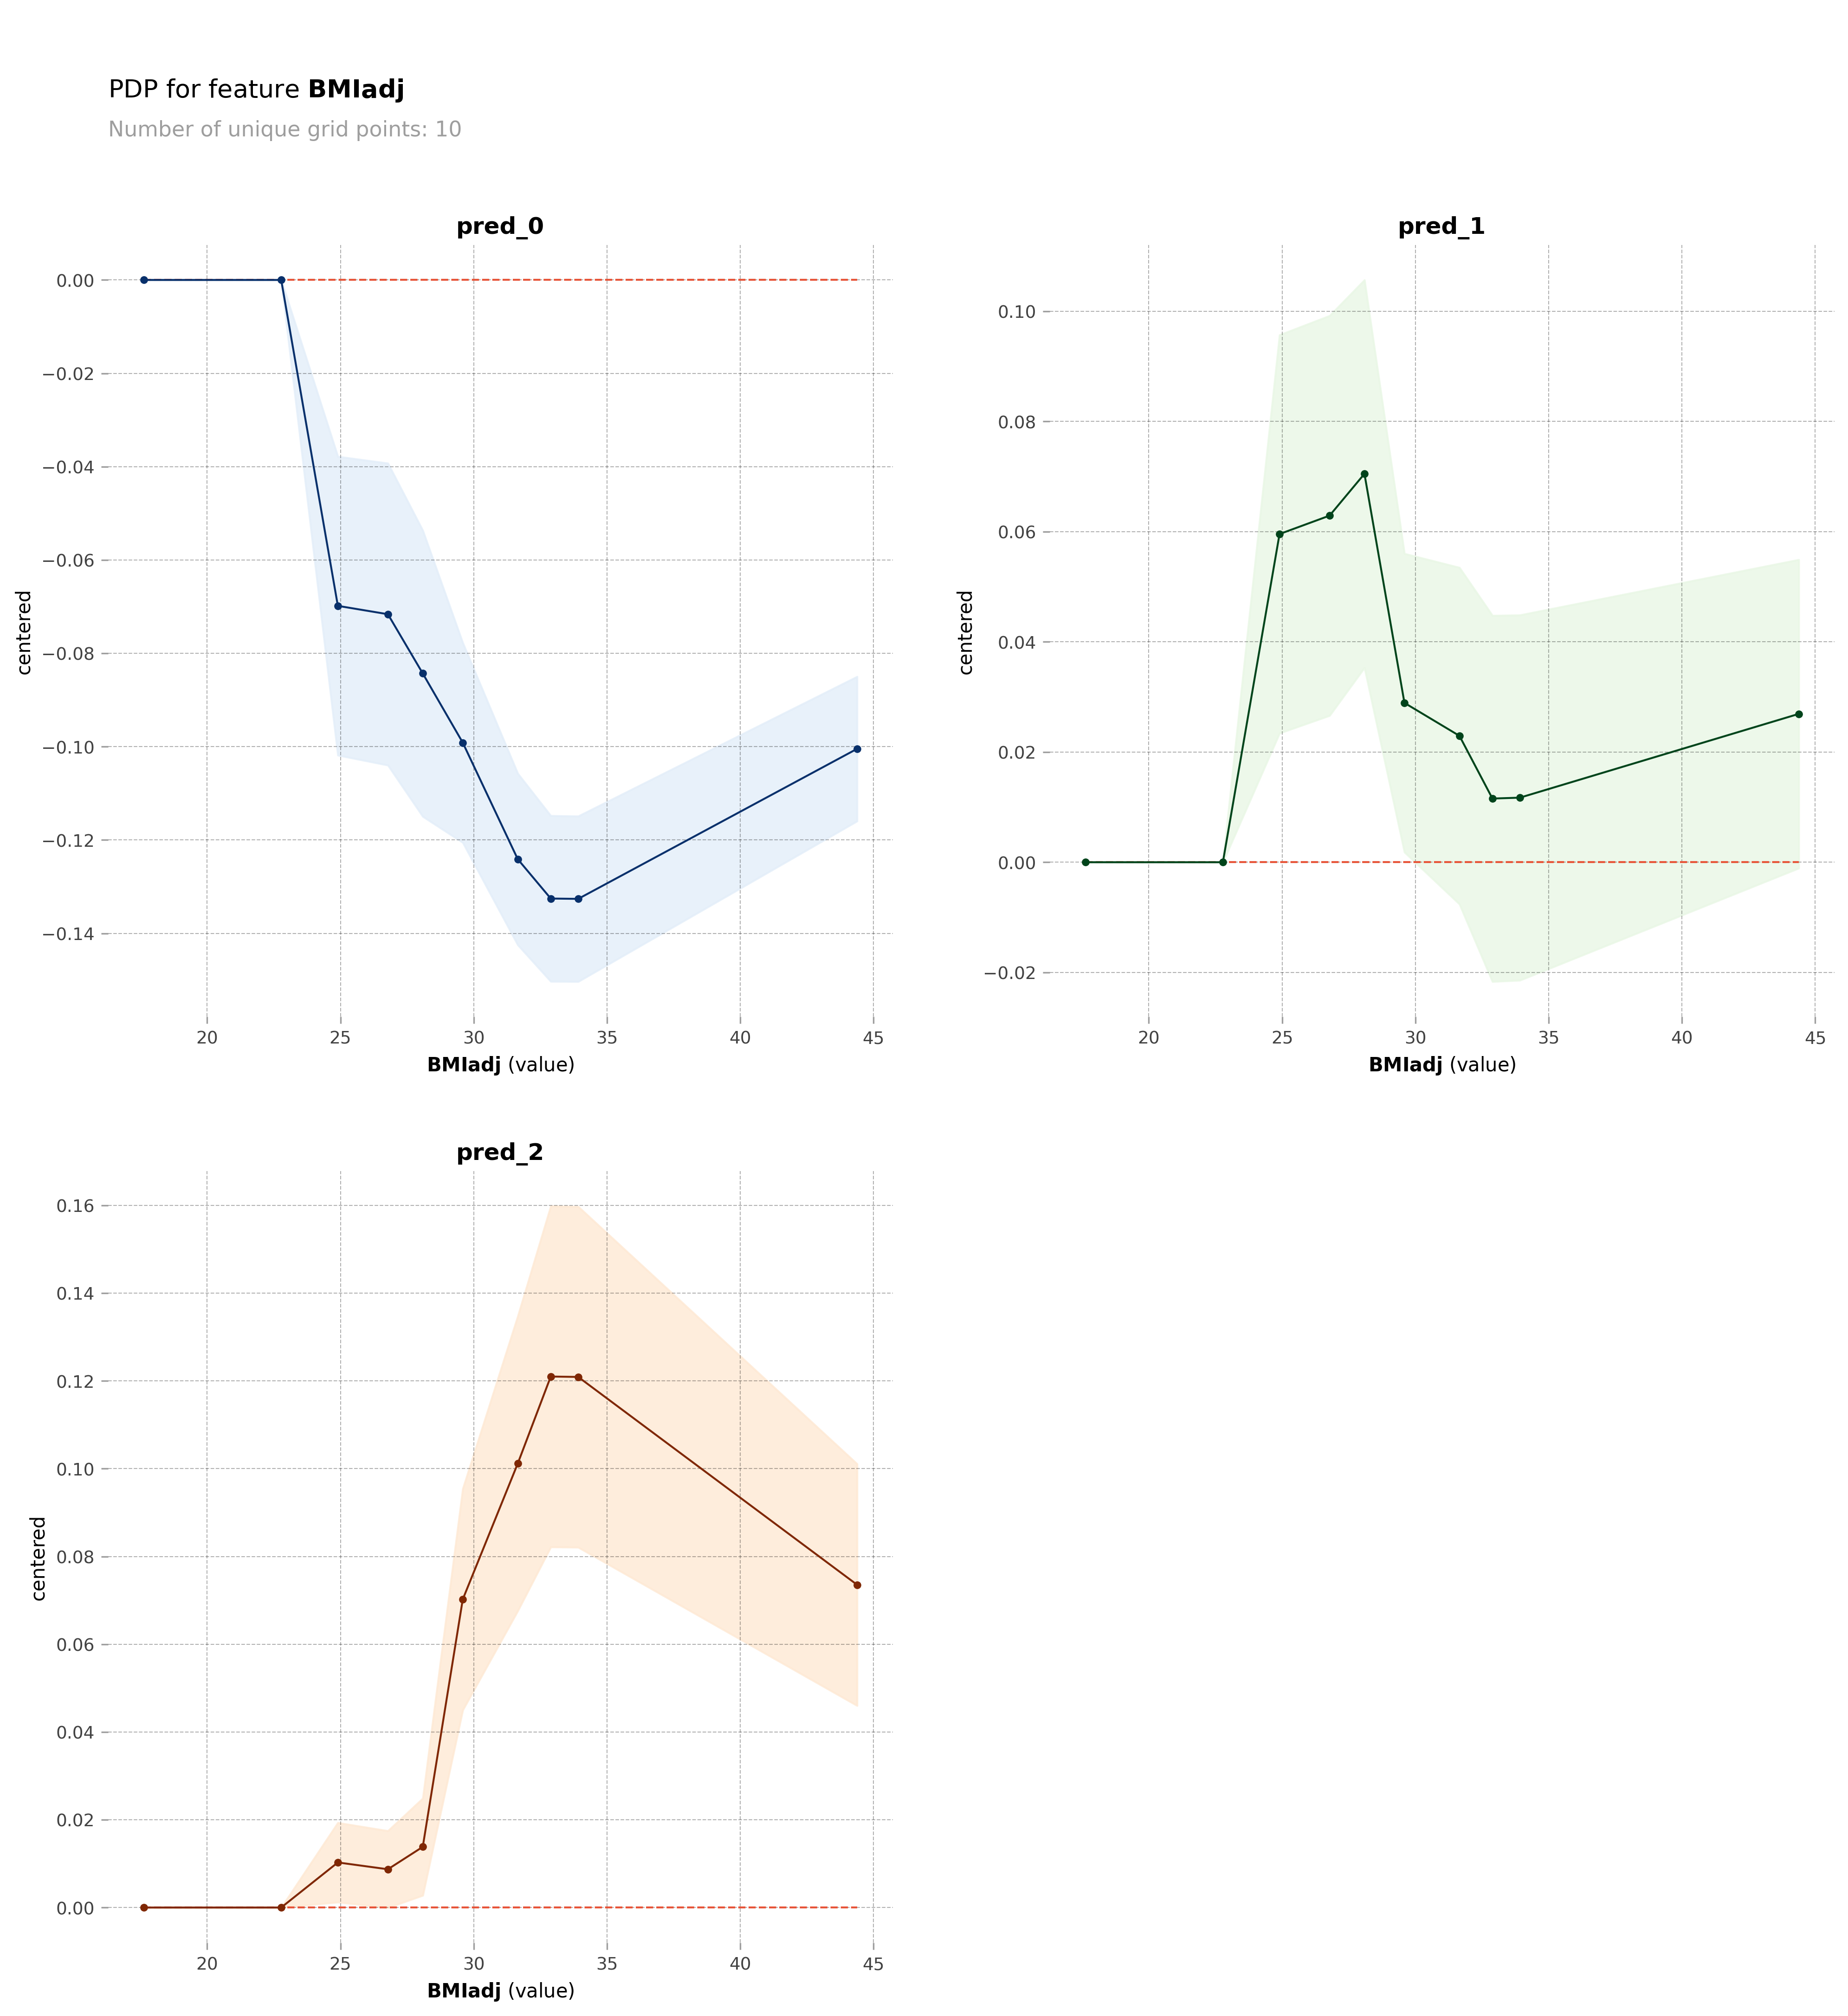

<Figure size 800x1600 with 0 Axes>

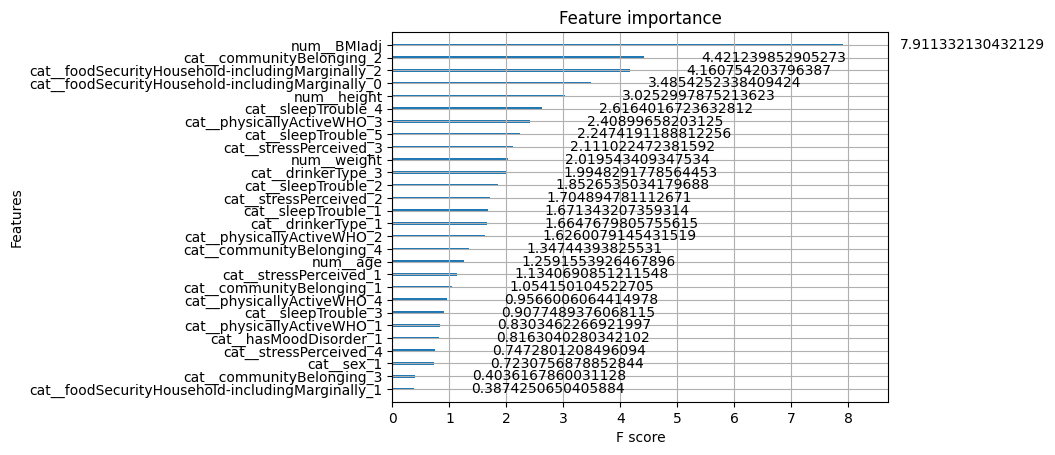

In [ ]:

# Specify the feature
feature_of_interest = "BMIadj"

# Extract the best estimator
best_model = searchXG.best_estimator_

# Create DataFrame with feature names
df = pd.DataFrame(X, columns=features)

# Generate PDP for a specific feature
dp_dist = pdp.PDPIsolate(model=best_model, model_features=features, feature_name=feature_of_interest, feature=feature_of_interest, df=df, n_classes=3)
fig, axes = dp_dist.plot(engine='matplotlib')

xgb_model = best_model.named_steps['classifier']
preprocessing_step_names = [name for name, _ in best_model.steps if name != 'classifier']
preprocessed_feature_names = best_model.named_steps[preprocessing_step_names[-1]].get_feature_names_out()

# Set feature names to the booster object
xgb_model.get_booster().feature_names = list(preprocessed_feature_names)

# Plot feature importance based on gain
plt.figure(figsize=(8, 16))
xgb.plot_importance(xgb_model.get_booster(), importance_type='gain')
plt.show()


##Comparing F1-scores across models using ANOVA

F-statistic: 6.623652290287017
p-value: 0.0010766217416661094
There is a statistically significant difference among group means.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
    DT    KNN  -3.7352  0.711 -13.1444  5.6741  False
    DT     RF  11.1659 0.0146   1.7566 20.5751   True
    DT     XG   1.1764 0.9858  -8.0165 10.3694  False
   KNN     RF   14.901 0.0007   5.4917 24.3103   True
   KNN     XG   4.9116  0.485  -4.2814 14.1045  False
    RF     XG  -9.9895 0.0288 -19.1824 -0.7965   True
-----------------------------------------------------


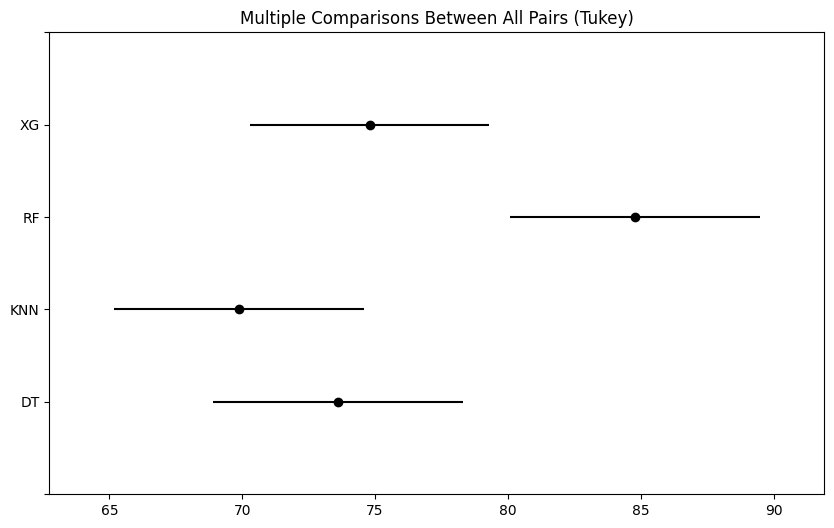

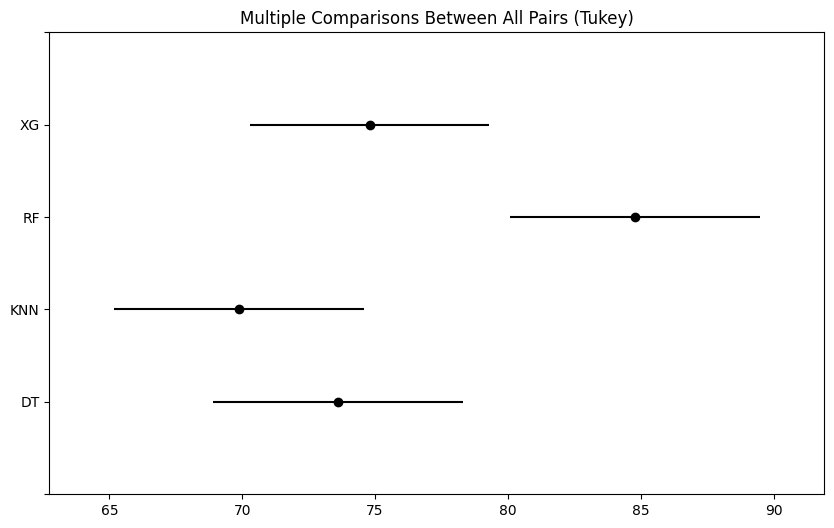

In [ ]:
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(np.array(f1s[0]), np.array(f1s[1]), np.array(f1s[2]), np.array(f1s[3]))

# Print the results
print("F-statistic:", f_statistic)
print("p-value:", p_value)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("There is a statistically significant difference among group means.")
else:
    print("Fail to reject null hypothesis: There is no statistically significant difference among group means.")


# Combine all the data into a single array and create a corresponding group labels array
data = np.concatenate((np.array(f1s[0]), np.array(f1s[1]), np.array(f1s[2]), np.array(f1s[3])))
group_labels = ['DT'] * len(f1s[0]) + ['RF'] * len(f1s[1]) + ['KNN'] * len(f1s[2]) + ['XG'] * len(f1s[3])

# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(data, group_labels)

# Print the summary of the test results
print(tukey_results)

# Plot the results if needed
tukey_results.plot_simultaneous()